**Содержание темы**

1. [Практический ноутбук 1](https://colab.research.google.com/drive/1R9XFt3kobaoX9z3wjFTIIR6DY_dCXSDE?usp=sharing)

2. Практический ноутбук 2


## Инфо по выделенным ресурсам

Даннывй служебный код помогает понять тип графической карты подключенной к ноутбуку


In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
!pip install -q psutil
!pip install -q humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
process = psutil.Process(os.getpid())
print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
print("GPU Model: ", gpu.name)

Gen RAM Free: 12.8 GB  | Proc size: 118.3 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB
GPU Model:  Tesla P100-PCIE-16GB


## Загрузка библиотеки

In [ ]:
# загрузка Пандас
import pandas as pd 

# загрузка Numpy
import numpy as np 

# загрузка random
import random

# загрузка из tensorflow
# оптимайзер для обучения нс
from tensorflow.keras.optimizers import Adam

# Два варианта сборки моделей
from tensorflow.keras.models import Sequential, Model 

# Стандартные слои моделей нс
from tensorflow.keras.layers import concatenate, Reshape, Input, Dense, Dropout, Conv1D, LSTM, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization, Flatten, GlobalAveragePooling1D, Activation, GlobalMaxPooling1D

# функция ошибки для обучения нс
from tensorflow.keras.losses import MAE

# для отрисовки дерева слоев нс
from tensorflow.keras.utils import plot_model

# Нормировщики данных
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

# Для генерации выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt 

# для загрузки данных по ссылке
import gdown

# модуль подсчета времени
import time

## Генетические алгоритмы для обучения нейронных сетей

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (File->Save a copy in Drive...). Свою копию вы сможете изменять и запускать.

## Подбор архитектуры свёрточной сети

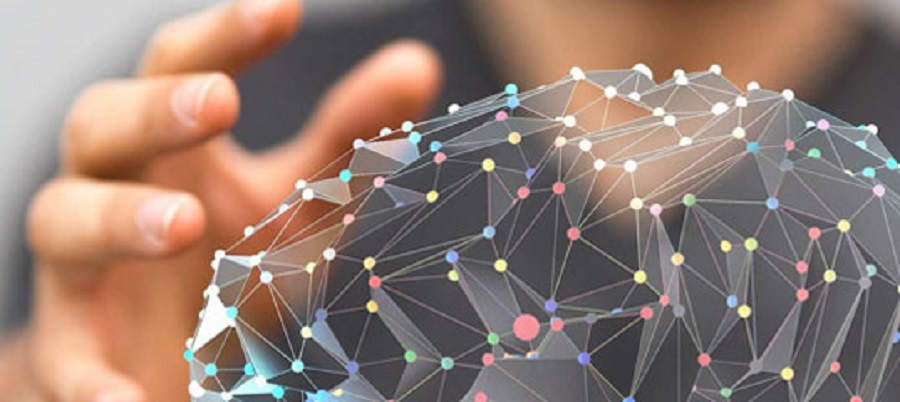

## Задача: Предсказание стоимости акций Лукойла

В лекции УИИ по обработтке временых рядов использовались акции Сбербанка.

Попробуем с помощью генетических алгоритм найти архитектуру НЕЛИНЕЙНОЙ нейронной сети, которая как можно лучше будет прогнозировать значени акции на один шаг на основе знаний о стоимости акций на определенном количестве шагов до этого момента.

###Загрузка данных

Код по загрузке данных для поиска архитектуры нейронной сети аналогичен коду в лекции

"Базовый блок | Обработка временных рядов с помощью нейронных сетей (Практика 2) | УИИ"

Загрузим данные акций за 16-17 года и 18-19 года:

In [ ]:
# Загрузка датасетов из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/16_17.csv', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/18_19.csv', None, quiet=True)

'18_19.csv'

Переведем данные в DataFrame:

In [ ]:
# Чтение данных в таблицу pandas
base_data = pd.read_csv('16_17.csv', sep=';')

Посмотрим содержимое таблицы и выведем пример нулевой строки:

In [ ]:
# Чтение данных в таблицу pandas
base_data = pd.read_csv('16_17.csv', sep=';')
# Вывод первых строк таблицы
base_data.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,04.01.2016,10:00:00,2351.0,2355.8,2350.0,2350.0,2547
1,04.01.2016,10:01:00,2352.9,2355.7,2350.0,2355.7,195
2,04.01.2016,10:02:00,2355.6,2356.0,2351.4,2354.1,257
3,04.01.2016,10:03:00,2354.5,2355.0,2351.2,2353.7,763
4,04.01.2016,10:04:00,2353.1,2353.9,2353.1,2353.6,231


каждая строка соответсвует минутному отрезку

In [ ]:
base_data.shape

(263925, 7)

Изучив содержимое таблиц, снова их подгрузим, но уже сразу удалим ненужные столбцы по дате и времени:

In [ ]:
# Пример данных из нулевой строки
print(base_data.values[0])

['04.01.2016' '10:00:00' 2351.0 2355.8 2350.0 2350.0 2547]


In [ ]:
# Чтение данных в таблицы с удалением ненужных столбцов
data16_17 = pd.read_csv('16_17.csv', sep=';').drop(columns=['DATE', 'TIME'])
data18_19 = pd.read_csv('18_19.csv', sep=';').drop(columns=['DATE', 'TIME'])

# Проверка формы данных
print(data16_17.shape) 
print(data18_19.shape) 

(263925, 5)
(217947, 5)


In [ ]:
# Пример данных одного датасета
d = data18_19

print(d.shape[0])                         # Всего записей (строк)
print(d.shape[1])                         # Количество столбцов
print(d.iloc[0])                          # Пример нулевой строки данных

217947
5
OPEN      3341.0
MAX       3356.0
MIN       3340.0
CLOSE     3355.0
VOLUME    6088.0
Name: 0, dtype: float64


Объединим таблицы в одну общую:

Тут мы отойдем от кода лекции и изменим размер используемых данных. Нам предстоит проводить множество экспериментов по поиску нейронной сети и слишком большой объем данных сильно замедлит поиск. 

Мы возьмем в изучение строки по акциям каждые 1 минут, указав `[::15]` при формировании объединенного датафрейма  

In [ ]:
# Создание общего набора данных из двух датасетов
data = pd.concat([data16_17, data18_19]).iloc[::15].to_numpy()

Посмотрим размерность новой таблицы:

In [ ]:
print(data.shape) 

(32125, 5)


Создадим словарь из названия столбцов и выведем его на экран:

In [ ]:
# Задание текстовых меток каналов данных (столбцов)
CHANNEL_NAMES = ['Open', 'Max', 'Min', 'Close', 'Volume']

# Получение словаря с именами и индексами каналов данных
CHANNEL_INDEX = {name: chan for chan, name in enumerate(CHANNEL_NAMES)}
print(CHANNEL_INDEX)

{'Open': 0, 'Max': 1, 'Min': 2, 'Close': 3, 'Volume': 4}


###Иллюстрация данных в графическом виде

Выведем данные для дальнейшей работы. Данные будут отображаться с позиции с номером `start`, длиной `length` отчетов. Отрисуем четыре линии со значениями OPEN, MIN, MAX, CLOSE и гистограммы по объему продаж:


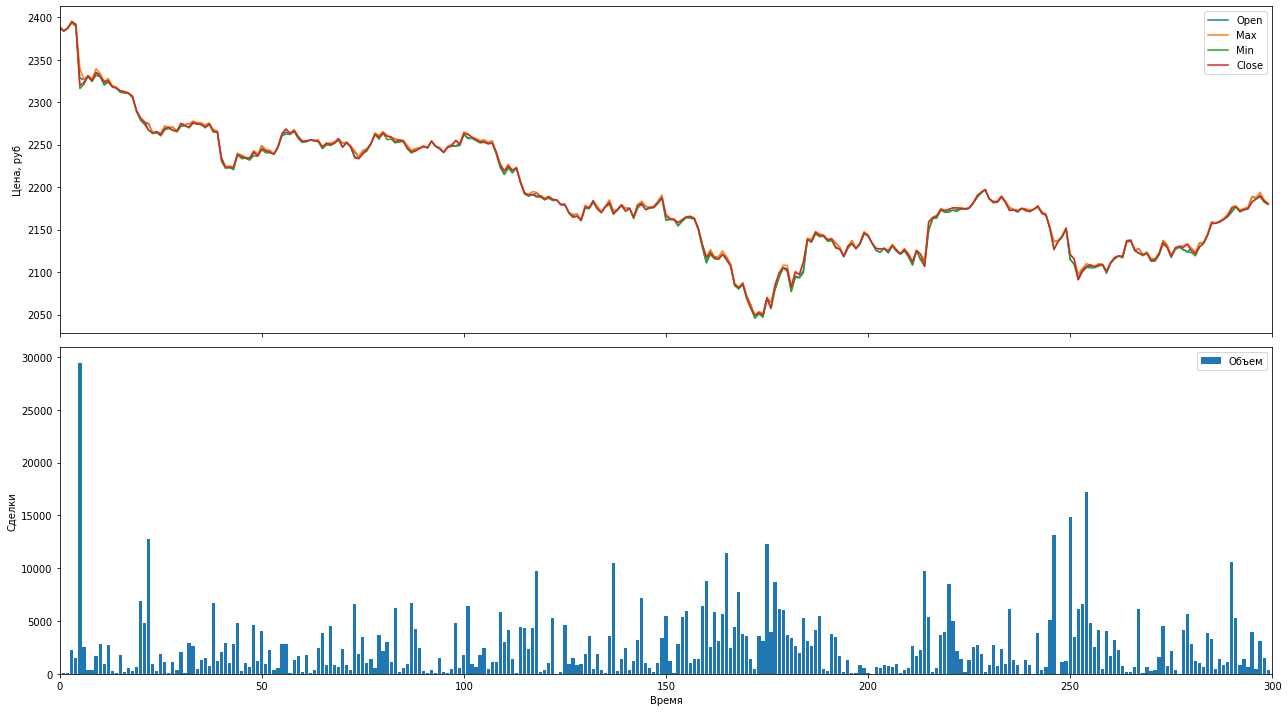

In [ ]:
# Отображение исходных данных от точки start и длиной length
start = 100
length = 300

# Задание полотна для графиков - два подграфика один под другим с общей осью x
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

# Четыре основных канала - open, max, min, close
for chn in range(4):
    # Отрисовка одного канала данных
    # От начальной точки start длиной length
    ax1.plot(data[start:start + length, chn],
             label=CHANNEL_NAMES[chn])
ax1.set_ylabel('Цена, руб')
ax1.legend()

# Канал volume (объем)
ax2.bar(x=np.arange(length), 
        height=data[start:start + length, CHANNEL_INDEX['Volume']],
        label='Объем')
ax2.set_ylabel('Сделки')
ax2.legend()

plt.xlabel('Время')
# Регулировка пределов оси x
plt.xlim(0, length)
# Указание расположить подграфики плотнее друг к другу
plt.tight_layout()
# Фиксация графика
plt.show()

### Подготовка выборок данных для нейросети




In [ ]:
# Словарь каналов данных с их индексами
print(CHANNEL_INDEX)

{'Open': 0, 'Max': 1, 'Min': 2, 'Close': 3, 'Volume': 4}


Установим гиперпараметры, отберем входные и выходные параметры. 300 отчетов, 30 тысяч примеров пойдут в проверочную выборку:

In [ ]:
# Задание гиперпараметров
CHANNEL_X = CHANNEL_NAMES                 # Отбор каналов входных данных
CHANNEL_Y = ['Close']                     # Отбор каналов данных для предсказания
SEQ_LEN = 300                             # Длина прошедших данных для анализа
BATCH_SIZE = 32                           # Объем батча для генератора
TEST_LEN = 3000                          # Объем тестовой выборки
TRAIN_LEN = data.shape[0] - TEST_LEN      # Объем обучающей выборки

Определим, какие данные пойдут в выборки. Разделим основной набор данных на обучающую и тестовую выборки. Обязательно нормируем данные. То же самое сделаем с выходными данными. При помощи генератора создадим выборки для обучения и проверки:

In [ ]:
# Формирование списков индексов каналов данных для входных и выходных выборок
chn_x = [CHANNEL_INDEX[c] for c in CHANNEL_X]
chn_y = [CHANNEL_INDEX[c] for c in CHANNEL_Y]

# Проверка результата
print(chn_x, chn_y)

# Разделение данных на тренировочный и тестовый наборы
# 2*SEQ_LEN - для разрыва между тренировочными и тестовыми данными 
# варьируемый параметр, страховка от пересечения
data_train, data_test = data[:TRAIN_LEN], data[TRAIN_LEN + 2*SEQ_LEN:]

# Отбор входных данных
x_data_train, x_data_test = data_train[:, chn_x], data_test[:, chn_x]

# Масштабирование данных
x_scaler = MinMaxScaler()
x_scaler.fit(x_data_train)
x_data_train = x_scaler.transform(x_data_train)
x_data_test = x_scaler.transform(x_data_test)

# Отбор выходных данных
y_data_train, y_data_test = data_train[:, chn_y], data_test[:, chn_y]

# Масштабирование данных
y_scaler = MinMaxScaler()
y_scaler.fit(y_data_train)
y_data_train = y_scaler.transform(y_data_train)
y_data_test = y_scaler.transform(y_data_test)

# Проверка формы данных
print(f'Train data: {x_data_train.shape}, {y_data_train.shape}')
print(f'Test  data: {x_data_test.shape}, {y_data_test.shape}')

# Создание генератора для обучения
train_datagen = TimeseriesGenerator(x_data_train, 
                                    y_data_train,
                                    length=SEQ_LEN,
                                    stride=1,
                                    sampling_rate=1,
                                    batch_size=BATCH_SIZE)

# Аналогичный генератор для валидации при обучении
val_datagen = TimeseriesGenerator(x_data_test, 
                                  y_data_test,
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)

# Проверка формы выдаваемого генератором результата
print(f'Train batch x: {train_datagen[0][0].shape}, y: {train_datagen[0][1].shape}')

[0, 1, 2, 3, 4] [3]
Train data: (29125, 5), (29125, 1)
Test  data: (2400, 5), (2400, 1)
Train batch x: (32, 300, 5), y: (32, 1)


In [ ]:
inputShape = train_datagen[0][0].shape
print(inputShape)
outputShape = train_datagen[0][1].shape
print(outputShape)

(32, 300, 5)
(32, 1)


Не забудем про тестовую выборку. Также при помощи генератора сформируем окончательные тестовые выборки:

In [ ]:
# Генератор тестовой выборки, генерирует один батч на всю выборку
test_datagen = TimeseriesGenerator(x_data_test, 
                                   y_data_test,
                                   length=SEQ_LEN,
                                   stride=1,
                                   sampling_rate=1,
                                   batch_size=x_data_test.shape[0])

# Формирование тестовой выборки из генератора
x_test, y_test = test_datagen[0]

# Проверка формы тестовой выборки
print(f'Test x: {x_test.shape}, y: {y_test.shape}')

Test x: (2100, 300, 5), y: (2100, 1)


## Сервисные функции

также из лекции "Базовый блок | Обработка временных рядов с помощью нейронных сетей (Практика 1) | УИИ"

Вспомним эти сервисные функции, которые упростят дальнейшие эксперименты с архитектурами НС:
- `get_pred()` – обученная модель. Предсказывает результат, который возвращается к ненормированным данным;
- `correlate()` – расчет коэффициента автокорреляции;
- `show_predict()` – построение графиков предсказания и верных ответов;
- `auto_corr()` – расчет и построение графика автокорреляции;

In [ ]:
def get_pred(currModel,
             xVal,
             yVal,
             yScaler
             ):
  '''
  Функция расчетов прогнозирования сети.

  -----------------
  Входные данные:
  currModel - нейронная сеть;
  xVal - x тестовая выборка;
  yVal - y тестовая выборка;
  yScaler - скейлер данных.
  -----------------
  На выходе функции:
  predVal - результаты предсказания;
  yValUnscaled - правильные ответы в исходной размерности
  (какими они были до нормирования).

  '''
  # Вычисление и деномализация предсказания
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  # Денормализация верных ответов
  yValUnscaled = yScaler.inverse_transform(yVal)
  # И возвращаем исходны масштаб данных, до нормализации
  return (predVal, yValUnscaled)


# Функция расёта корреляции дух одномерных векторов

def correlate(a,
              b
              ):
  '''
  Функция расчета корреляции между двумя списками.
    
  -----------------
  Входные данные:
  a - первый вектор;
  b - второй вектор;
  -----------------
  На выходе функции:
  val - значение корреляции.
  '''

  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val
  # аналог функции в нампи np.corrcoef(a, b)[0, 1]


def show_predict(start,
                 step,
                 channel,
                 predVal,
                 yValUnscaled
                 ):
  '''
  Функция визуализирует графики, что предсказала сеть
  и какие были правильные ответы.  

  -----------------
  Входные данные:
  start - точка с которой начинаем отрисовку графика
  step - длина графика, которую отрисовываем
  channel - какой канал отрисовываем
  predVal - результаты предсказания;
  yValUnscaled - правильные ответы в исходной размерности
  -----------------
  На выходе функции:
  Функция визуализирует графики.
  '''
  plt.figure(figsize=(12, 5))
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  


def auto_corr(channels,
              corrSteps,
              predVal,
              yValUnscaled,
              plot_graf = True,
              return_data = False):
  '''
  Функция расчета корреляции и автокорреляции.
  А также может визуализировать результаты в графики.
    
  -----------------
  Входные данные:
  channels - по каким каналам отображать корреляцию;
  corrSteps - количество шагов смещения назад для рассчёта корреляции;
  predVal - результаты предсказания;
  yValUnscaled - правильные ответы в исходной размерности;
  plot_graf - рисовать или нет графики (по умолчанию True);
  return_data - выводить или нет данные (по умолчанию False).
  -----------------
  На выходе функции:
  Если plot_graf = True функция рисует корреляцию спрогнозированного сигнала
  с исходным, смещая на различное количество шагов назад
  Если return_data = True функция выводит значения:
  corr - корреляции по шагам исходных знчений с предсказанными;
  own_corr - корреляции исходных знчений с самими собой
  '''
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    if plot_graf: #Если нужно показать график
      plt.figure(figsize=(12, 5))
      plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')

  if plot_graf: #Если нужно показать график
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

  if return_data: #Если нужно вернуть массивы автокорреляции
     return corr, own_corr

In [ ]:
def get_pred(currModel, xVal, yVal, yScaler):
  '''
  Функция рассчитываем результаты прогнозирования сети
  В аргументы принимает сеть (currModel) и проверочную выборку
  Выдаёт результаты предсказания predVal
  И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
  '''
  # Вычисление и деномализация предсказания
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  # Денормализация верных ответов
  yValUnscaled = yScaler.inverse_transform(yVal)
  # И возвращаем исходны масштаб данных, до нормализации
  return (predVal, yValUnscaled)


# Функция расёта корреляции дух одномерных векторов

def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val # аналог функции в нампи np.corrcoef(a, b)[0, 1]


def show_predict(start, step, channel, predVal, yValUnscaled):
  '''
  Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
  start - точка с которой начинаем отрисовку графика
  step - длина графика, которую отрисовываем
  channel - какой канал отрисовываем
  '''
  plt.figure(figsize=(12, 5))
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  


def auto_corr(channels, corrSteps, predVal, yValUnscaled, plot_graf = True, return_data = False):
  '''
  Функция рисуем корреляцию прогнозированного сигнала с правильным
  Смещая на различное количество шагов назад
  Для проверки появления эффекта автокорреляции
  channels - по каким каналам отображать корреляцию
  corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
  showGraf - показываем график или нет
  returnData - возвращаем массивы автокорреляции или нет
  '''
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    if plot_graf: #Если нужно показать график
      plt.figure(figsize=(12, 5))
      plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')

  if plot_graf: #Если нужно показать график
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

  if return_data: #Если нужно вернуть массивы автокорреляции
     return corr, own_corr

# Подбор нелинейной архитектуры

В данном разделе мы будем искать оптимальный состав нелинейной нейросети

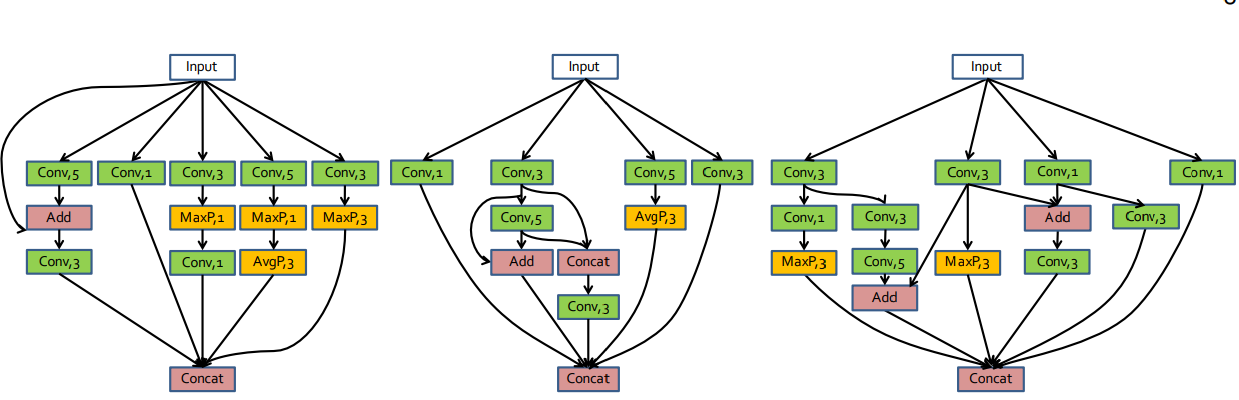

Как и в задаче с ленейной архитектурой нам нужно сначала определить определить логику построения неленейной нейронной сети с учетом более широких возможностей модуля `Model()`

----
**За основу берется очередная гипотеза построения уже нелинейной сети и далее она оттачивается генетикой**

 Будем искать сеть со следующей логикой построения:
 
 **Входной блок**

*   0 - делаем ли нормализацию вначале
*   1 - тип входного блока Dense или Conv
*   2 - размер cвёрточного или полносвязного слоя 
*   3 - ядро для свёрточного слоя
*   4 - функция активации входного слоя

----
*   5 - размер ядра для всех слоев MaxPooling в сети
*   6 - размер rate для всех Dropout
*   7 - количество веток lstm
*   8 - количество веток  dense
*   9 - количество веток  conv
----


**Первый скрытый блок**

*   10 - делаем ли ветку
*   11 - размер слоя (LSTM, Dense, Conv)
*   12 - размер ядра, используется если свёрточная ветка
*   13 - размер strides, используется если свёрточная ветка
*   14 - тип Рadding, используется если свёрточная ветка
*   15 - функция активации ветки
*   16 - Делаем ли пуллинг|дропаут после Conv и Dense соответсвенно

**Второй скрытый блок**

*   17 - делаем ли ветку
*   18 - размер слоя (LSTM, Dense, Conv)
*   19 - размер ядра, используется если свёрточная ветка
*   20 - размер strides, используется если свёрточная ветка
*   21 - тип Рadding, используется если свёрточная ветка
*   22 - функция активации ветки
*   23 - Делаем ли пуллинг|дропаут после Conv и Dense соответсвенно


**Третий скрытый блок**

*   24 - делаем ли ветку
*   25 - размер слоя (LSTM, Dense, Conv)
*   26 - размер ядра, используется если свёрточная ветка
*   27 - размер strides, используется если свёрточная ветка
*   28- тип Рadding, используется если свёрточная ветка
*   29 - функция активации ветки
*   30 - Делаем ли пуллинг|дропаут после Conv и Dense соответсвенно

**Четвертый скрытый блок**

*   31 - делаем ли ветку
*   32 - размер слоя (LSTM, Dense, Conv)
*   33 - размер ядра, используется если свёрточная ветка
*   34 - размер strides, используется если свёрточная ветка
*   35 - тип Рadding, используется если свёрточная ветка
*   36 - функция активации ветки
*   37 - Делаем ли пуллинг|дропаут после Conv и Dense соответсвенно

**Пятый скрытый блок**

*   38 - делаем ли ветку
*   39 - размер слоя (LSTM, Dense, Conv)
*   40 - размер ядра, используется если свёрточная ветка
*   41 - размер strides, используется если свёрточная ветка
*   42 - тип Рadding, используется если свёрточная ветка
*   43 - функция активации ветки
*   44 - Делаем ли пуллинг|дропаут после Conv и Dense соответсвенно

----
Блоки:
 - проверки объема данных для применения Flatten() или GlobalAveragePooling1D(), чтобы не было проблем с ОЗУ
 - конкетинации для вытягивания в вектор значений и передачи в выходной блок из Dense слоев
----

**Выходной блок**

*   45 - делаем ли препоследний полносвязный
*   46 - размер препоследнего полносвязного слоя
*   47 - Фукнция активации препоследнего полносвязного слоя

## Функция формирования модели из бота

Реализуем вышеуказанную логику в функции, которая будет собирать модель на основе значений прихдящих в нее в виде бота, являющегося списком значений

Применим так же:
- максимальное количеств веток, их будет максимум 5ть
- возможность использывания 3х типов веток LSTM, Dense, Conv путем случайного выбора количествасоответствующих веток по очереди. Сначала ищем к-во LSTM от 0 до 2х, затем ищем к-во Dense от остатка и далее ищем к-во Conv от остатка. Так мы добавим вариативность в поиске типов сеток. 
- для формирования значений размера свертки и количества нейронов слоев будем использывать степень `2`. То есть будем искать значение в степень которого мы возведем двойку. 
- применим ход, который помогает обходить проблему памяти, возникающую иногда при применении слоя `Flatten()`, а далее полносвязного слоя. Мы сделаем условие, что при превышению размера слоя добавленного до `Flatten()` контрольного значения, будет применен иной вытягивающий слой `GlobalAveragePooling1D()`

Нам нужно будет отсчитывать ген с началом ветки:
- с учетом количества каждого типа веток
- и с учетом количества генов используемых для описания ветки. У нас он оно, так же как количество самих веток(их 5ть), фиксировано и равно 7ми

Так как логика одна, но параметры будут меняться, включая индекс в цикле, то это лучше счетчик реализовать через функцию. 

Для простой логике удобнее применять лямбда функции.

Создадим в самой функции счеткик со следующей логикой.

In [ ]:
a = lambda c, d, i: c + d*i 
c = 10
d = 7
for i in range(3):
  c = a(c,d,i)
  print(c)

10
17
31


Часть выведенных данных показана пока не закоментированы знаком `#` функции `print()`.

Это удобно размещать подобные строки для контроля важных значений при оттачивании кода и обнаружения возможных ошибок

In [ ]:
# Создаём сеть (net - список параметров)
def create_randnet(net,
                   xLen,
                   channels,
                   num_cls,
                   control_level_shape = 10**4):
  '''
  Функция формирования нелинейной нейронной ссети из бота.
  
  -----------------
  Входные данные:
  net - полученный бот со списком значений для формирования сети
  xLen - размер анализируемых данных до предсказания;
  channels - количество каналов данных;
  num_cls - количество предсказываемых шагов;
  control_level_shape - парамметр при превышению которого будет применен 
  слой GlobalAveragePooling1D, а не Flatten (по умолчанию 10'000).
  -----------------
  На выходе функции:
  model - нелинейная нейронная сеть Model()
  '''
  # определяем форму входных данных
  input_shape = (xLen, channels)

  '''
  Входной блок
  '''
  makeFirstNormalization = net[0] # Делаем ли нормализацию в начале
  FirstDenseorConv = net[1]       # Тип входного блока Dense или Conv
  firstSize = 2 ** net[2]         # размер cвёрточного слоя или к-во нейронов
  firstConvKernel = net[3]        # Ядро для водного свёрточного слоя
  activation0 = net[4]            # Функция активации входного слоя


  '''
  Данные для внутренних блоков
  '''
  maxPoolKernel = net[5]          # Ядро пуллинга для всех Polling слоев
  dropoutRate =  net[6]           # размер дропаута для всех Dropout слоев
  # формировние типа веток
  qtyLstmways = net[7]            # количество веток lstm 
  qtyDenseways = net[8]           # количество веток  dense
  qtyConvways = net[9]            # количество веток  conv


  '''
  Первый скрытый блок
  '''
  makeway1 = net[10]               # Делаем ли ветку
  waySize1 = 2 ** net[11]          # размер слоя (LSTM, Dense, Conv)
  wayKernel1 = net[12]             # Размер Kernel если свёрточная ветка
  waysriides1 = net[13]           # Sriides если свёрточная ветка
  waypadding1 = net[14]           # Рadding если свёрточная ветка
  activation1 = net[15]           # Функция активации ветки
  wayPoolDrop1 = net[16]          # Делаем ли пуллинг|дропаут соответственно

  '''
  Второй скрытый блок
  '''
  makeway2 = net[17]               # Делаем ли ветку
  waySize2 = 2 ** net[18]          # размер слоя (LSTM, Dense, Conv)
  wayKernel2 = net[19]             # Размер Kernel если свёрточная ветка
  waysriides2 = net[20]            # Sriides если свёрточная ветка
  waypadding2 = net[21]            # Рadding если свёрточная ветка
  activation2 = net[22]            # Функция активации ветки
  wayPoolDrop2 = net[23]           # Делаем ли пуллинг|дропаут соответственно

  '''
  Третий скрытый блок
  '''
  makeway3 = net[24]               # Делаем ли ветку
  waySize3 = 2 ** net[25]          # размер слоя (LSTM, Dense, Conv)
  wayKernel3 = net[26]             # Размер Kernel если свёрточная ветка
  waysriides3 = net[27]            # Sriides если свёрточная ветка
  waypadding3 = net[28]            # Рadding если свёрточная ветка
  activation3 = net[29]            # Функция активации ветки
  wayPoolDrop3 = net[30]           # Делаем ли пуллинг|дропаут соответственно

  '''
  Четвертый скрытый блок
  '''
  makeway4 = net[31]               # Делаем ли ветку
  waySize4 = 2 ** net[32]          # размер слоя (LSTM, Dense, Conv)
  wayKernel4 = net[33]             # Размер Kernel если свёрточная ветка
  waysriides4 = net[34]            # Sriides если свёрточная ветка
  waypadding4 = net[35]            # Рadding если свёрточная ветка
  activation4 = net[36]            # Функция активации ветки
  wayPoolDrop4 = net[37]           # Делаем ли пуллинг|дропаут соответственно

  '''
  Пятый скрытый блок
  '''
  makeway5 = net[38]               # Делаем ли ветку
  waySize5 = 2 ** net[39]          # размер слоя (LSTM, Dense, Conv)
  wayKernel5 = net[40]             # Размер Kernel если свёрточная ветка
  waysriides5 = net[41]            # Sriides если свёрточная ветка
  waypadding5 = net[42]            # Рadding если свёрточная ветка
  activation5 = net[43]            # Функция активации ветки
  wayPoolDrop5 = net[44]           # Делаем ли пуллинг|дропаут соответственно

  '''
  Выходной dense блок
  '''
  makeDense = net[45]              # Делаем ли препоследний полносвязный
  denseSize = 2 ** net[46]         # Размер полносвязного слоя
  activation6 = net[47]            # Фукнция активации пятго слоя

  '''
  Список активационных функций
  '''
  activation_list = ['linear','relu', 'elu', 'selu' ,'tanh','softmax','sigmoid'] 

  '''
  Условия для формирования блоков
  _______________________________
  '''

  '''
  Входной блок Dense или Conv
  '''
  # Входной слой
  inputs = Input(input_shape)  

  # Если делаем нормализацию в начале
  if (makeFirstNormalization):    
    x = BatchNormalization()(inputs)

    if (FirstDenseorConv):
        x = Dense(firstSize, activation=activation_list[activation0])(x)
        x = Activation(activation_list[activation0])(x)
    else:
        x = Conv1D(firstSize,firstConvKernel, padding ='same')(x)
        x = Activation(activation_list[activation0])(x)
  # Если не делаем нормализацию в начале
  else:                           
    if (FirstDenseorConv):
        x = Dense(firstSize, activation=activation_list[activation0])(inputs)
        x = Activation(activation_list[activation0])(x)
    else:
        x = Conv1D(firstSize,firstConvKernel, padding ='same')(inputs)
        x = Activation(activation_list[activation0])(x)

  # Список для сборы выходов всех веток включая выход из inputs
  list_to_concat = [inputs]       


  '''
  ОПРЕДЕЛЕНИЕ ТИПА ВЕТОК
  '''
  gensway = 7 # количество генов в ветке
  # счетчик индексов
  idxgen = lambda idx0way, gensway, i: idx0way+gensway*i 
  
  
  '''
  Ветка слоев на основе Lstm
  '''
  idx0way = 10 # нулевой ген ветки Lst
  #print('qtyLstmways', net[7])
  if qtyLstmways: # если колиство веток Lstm больше 0
      #print('LSTM: ', idx0way)
      # Проходимся по каждому блоку
      for i in range(qtyLstmways):              
          idx0lay = idxgen(idx0way,gensway,i)
          #print('LSTM - ', idx0lay)
          if net[idx0lay]!=0: # Добавление блока
              x = LSTM(max(3, net[idx0lay+1]), return_sequences=True)(x)
              x = Activation(activation_list[net[idx0lay+5]])(x)
              x = Reshape((-1,1))(x)
              list_to_concat.append(x)  # Иначе сразу добавляем в список

  '''
  Ветка слоев на основе Dense
  '''
  idx0way += qtyLstmways*gensway # нулевой ген ветки Dense   
  #print('qtyDenseways',net[8])
  if qtyDenseways: # если колиство веток Dense больше 0
    # Проходимся по каждому блоку
      #print('DENSE: ', idx0way)
      for i in range(qtyDenseways):              
          idx0lay = idxgen(idx0way,gensway,i)
          #print('DENSE - ', idx0lay)
          if net[idx0lay]!=0: # Добавление блока
              x = Dense(net[idx0lay+1])(x)
              x = Activation(activation_list[net[idx0lay+5]])(x)
              if net[idx0lay+6]!=0:           # Добавление пулинга
                x = Dropout(dropoutRate)(x)
                x = Reshape((-1,1))(x)
                list_to_concat.append(x)  # Добавляем в список

              else: # Иначе сразу добавляем в список
                x = Reshape((-1,1))(x)
                list_to_concat.append(x)  

  '''
  Ветка слоев на основе Conv
  '''
  #print('qtyConvways' , net[9])
  idx0way += qtyDenseways*gensway # нулевой ген ветки Conv     
  if qtyConvways: # если колиство веток Conv больше 0
      # Проходимся по каждому блоку
      #print('CONV: ', idx0way)   
      for i in range(qtyConvways):              
          idx0lay = idxgen(idx0way,gensway,i)
          #print('CONV - ', idx0lay)  
          if net[idx0lay]!=0: # Добавление блока
              x = Conv1D(net[idx0lay+1], net[idx0lay+2],
                         strides = net[idx0lay+3],
                         padding = net[idx0lay+4])(x)
              x = Activation(activation_list[net[idx0lay+5]])(x)

              if net[idx0lay+6]!=0:           # Добавление пулинга
                x = MaxPooling1D(maxPoolKernel)(x)
                x = Reshape((-1,1))(x)
                list_to_concat.append(x)  # Добавляем в список
              else:   # Иначе сразу добавляем в список
                x = Reshape((-1,1))(x)
                list_to_concat.append(x)  

      
          list_to_concat.append(x)    # Добавляем в список

  '''
  Блок проверки размерности слоя
  Для применения Flatten() или GlobalAveragePooling1D()
  для вытягивания в вектор значений и передачи в выходной блок из Dense слоев
  '''
  # Проходим по всем значениям списка list_to_concat и делаем flatten
  for i in range(len(list_to_concat)):    
    if list_to_concat[i].shape != (None,0,1):
          # Получаем размерность последнего из добавленных слоев
        control_shape = list_to_concat[i].get_shape()

        if control_shape[-1]*control_shape[-2] < control_level_shape:
          # Добавляем слой Flatten
            list_to_concat[i] = Flatten()(list_to_concat[i])                           
        else:
            # Добавляем слой GlobalAveragePooling1D
            list_to_concat[i] = GlobalAveragePooling1D()(list_to_concat[i])             
    else:
      break

  '''
  Блок соединения веток и вытягивания в вектор
  '''
  # Соединяем значения списка в единое целое
  if len(list_to_concat) != 1:
     fin = concatenate(list_to_concat)
  
  # Иначе просто делаем flatten
  else:
    fin = x
    fin = Flatten()(fin)

  '''
  Выходной dense блок
  '''
  # Добавление полносвязного слоя
  if makeDense!=0:
    fin = Dense(denseSize)(fin)
    fin = Activation(activation_list[activation6])(fin)

  # выходной слой
  fin = Dense(num_cls)(fin)

  model = Model(inputs, fin)  # Создаем модель 
  return model                # Возвращаем моель

Как видно, уже для данной не слишком сложно, но вариативной схемы уже требуется 48 элементов для сбора в бот популяции

## Функция формирования случайного бота

Теперь нам нужна функция которая будет формировать список со случайными значениями, это случайных ботов популяции.

Так как каждое значение списка ответственно за определенную часть будущей модели, то диапозон значений в которых будет создаваться случайное значение должно четко соответствовать его будущей задаче!

Данную задачу можно реализовать через создания пустого списа и почередного добавления методом `append()` очередного случайного значения нужно типа и в диапозоне связанным с пааметром. 

Например:
- для формирования значений нейронов от 4 до 1024, нужно искать случайное значение степени двойки от 2 до 10 в виде `random.randint(2,10)`
- если нам нужен тригер "сделать/не сделать" слой, то это можно реализовать через значения 0 и 1, как `random.randint(0,1)`

- тип padding мы реализуем через `random.choice()` указав для случайного выбора требуемые значения `('valid','same')`

- если мы выбираем активационную функцию, то мы можем искать случайное значение индекса списка активационных функций

**Важно!**

 - Последовательность добавления значений в список бота, должна четко соответсовать порядку применения его значений в функции формирования сети. 
 - Максимальное количество веток `qtyways = 5` в боте будет задано неизменяемым, так как для придания ему настраиваемого вида требуется запрограммировать изменяемы вид бота и положения генов взависимости от заданного максимального количества веток.

Так мы можем расчитывать количество типа веток из максимамльного

In [ ]:
MAX_VETOK = 5
L = random.randint(0,1) # количество веток lstm
D = random.randint(0, MAX_VETOK-L) # количество веток dense
C = MAX_VETOK - L - D # количество веток conv
print(L,C,D,(L+D+C))

0 3 2 5


В коде формирования бота нейросети применим это для генов отвечающих за структуру сети

In [ ]:
def create_bot4net():
  '''
  Функция создания списка случайных параметров - бота

  -----------------
  Входные данные:
  отсутствуют
  -----------------
  На выходе функции:
  net - список параметров для линейной нс
  '''
  # количество внутренних веток, которые описаны нижн
  qtyways = 5

  '''
  Гены входного блока
  '''
  net = []
  net.append(random.randint(0,1))  # 0 Делаем или нет нормализацию
  net.append(random.randint(0,1))  # 1 Тип входного блока Dense или Conv
  net.append(random.randint(3,10)) # 2 размер cвёрточного слоя или к-во нейронов
  net.append(random.randint(2,7))  # 3 Ядро для водного свёрточного слоя
  net.append(random.randint(0,6))  # 4 Функция активации входного слоя

  '''
  Гены парамметров типов внутренних веток будут защищены от изменний
  '''
  net.append(random.randint(2,4))           # 5 Ядро пуллинга веток
  net.append(random.choice((0.1,0.2,0.3)))  # 6 размер дропаута веток
  
  # формировние типа веток
  qtyLstmways = random.randint(0,1)         # 7 количество веток lstm
  net.append(qtyLstmways)  # добавляем количество веток lstm

  qtyDenseways = random.randint(0,qtyways-qtyLstmways) # 8 количество веток dense
  net.append(qtyDenseways)# добавляем количество веток dense

  qtyConvways = qtyways - qtyLstmways - qtyDenseways # 9 количество веток conv
  net.append(qtyConvways) # добавляем количество веток conv

  '''
  Гены для первой ветки
  '''
  net.append(random.randint(0,1))  # 10 Делаем ли 1ю ветку
  net.append(random.randint(3,10)) # 11 размер слоя (LSTM, Dense, Conv) от 8 до 1024
  net.append(random.randint(2,7))  # 12 Размер Kernel если свёрточная ветка от 2 до 7
  net.append(random.randint(1,5))  # 13 Размер Strides если свёрточная ветка от 1 до 5
  net.append(random.choice(('valid','same'))) # 14 pading ветоки
  net.append(random.randint(0,6))  # 15 Функция активации ветки
  net.append(random.randint(0,1))  # 16 Делаем ли пуллинг|дропаут соответственно

  '''
  Гены для второй ветки
  '''
  net.append(random.randint(0,1))  # 17 Делаем ли 2ю ветку
  net.append(random.randint(3,10)) # 18 размер слоя (LSTM, Dense, Conv) от 8 до 1024
  net.append(random.randint(2,7))  # 19 Размер Kernel если свёрточная ветка от 2 до 7
  net.append(random.randint(1,5))  # 20 Размер Strides если свёрточная ветка от 1 до 5
  net.append(random.choice(('valid','same'))) # 21 pading ветоки
  net.append(random.randint(0,6))  # 22 Функция активации ветки
  net.append(random.randint(0,1))  # 23 Делаем ли пуллинг|дропаут соответственно

  '''
  Гены для третьей ветки
  '''
  net.append(random.randint(0,1))  # 24 Делаем ли 3ю ветку
  net.append(random.randint(3,10)) # 25 размер слоя (LSTM, Dense, Conv) от 8 до 1024
  net.append(random.randint(2,7))  # 26 Размер Kernel если свёрточная ветка от 2 до 7
  net.append(random.randint(1,5))  # 27 Размер Strides если свёрточная ветка от 1 до 5 
  net.append(random.choice(('valid','same'))) # 28 pading ветоки
  net.append(random.randint(0,6))  # 29 Функция активации ветки
  net.append(random.randint(0,1))  # 31 Делаем ли пуллинг|дропаут соответственно

  '''
  Гены для четвертой ветки
  '''
  net.append(random.randint(0,1))  # 31 Делаем ли 4ю ветку
  net.append(random.randint(3,10)) # 32 размер слоя (LSTM, Dense, Conv) от 8 до 1024
  net.append(random.randint(2,7))  # 33 Размер Kernel если свёрточная ветка от 2 до 7
  net.append(random.randint(1,5))  # 34 Размер Strides если свёрточная ветка от 1 до 5
  net.append(random.choice(('valid','same'))) # 35 pading ветоки
  net.append(random.randint(0,6))  # 36 Функция активации ветки
  net.append(random.randint(0,1))  # 37 Делаем ли пуллинг|дропаут соответственно

  '''
  Гены для пятоой ветки
  '''
  net.append(random.randint(0,1))  # 38 Делаем ли 5ю ветку
  net.append(random.randint(3,10)) # 39 размер слоя (LSTM, Dense, Conv) от 8 до 1024
  net.append(random.randint(2,7))  # 40 Размер Kernel если свёрточная ветка от 2 до 7
  net.append(random.randint(1,5))  # 41 Размер Strides если свёрточная ветка от 1 до 5
  net.append(random.choice(('valid','same'))) # 42 pading ветоки
  net.append(random.randint(0,6))  # 43 Функция активации ветки
  net.append(random.randint(0,1))  # 44 Делаем ли пуллинг|дропаут соответственно

  '''
  Гены для выходного блока
  '''
  net.append(random.randint(0,1))  # 45 Делаем ли дополнительный полносвязный слой
  net.append(random.randint(3,10)) # 46 Размер полносвязного слоя от 8 до 1024
  net.append(random.randint(0,6))  # 47 Функция активации
  return net

Создадим случаного бота функцией `create_bot4net()` и подадим в функцию формирования сети из бота - `create_randnet`

Часть выведенных данных показана пока не закоментированы знаком `#` функции `print()`.

Это удобно размещать подобные строки для контроля важных значений при оттачивании кода и обнаружения возможных ошибок

In [ ]:
bot = create_bot4net()
print(bot)
print('Длина бота', len(bot))
# Создаем модель createConvNet
model = create_randnet(bot,
                      inputShape[1], # количество подаваемых шагов в наборе
                      inputShape[2], # количество каналов данных в наборе
                      outputShape[1] # на сколько предсказываем 
                      )
# выводим слои модели 
#model.summary()                               

[1, 0, 8, 5, 3, 3, 0.1, 0, 2, 3, 0, 3, 6, 2, 'valid', 5, 1, 0, 5, 7, 5, 'valid', 4, 0, 1, 7, 6, 5, 'valid', 6, 1, 1, 6, 6, 2, 'valid', 4, 0, 1, 9, 2, 4, 'same', 0, 1, 1, 7, 2]
Длина бота 48


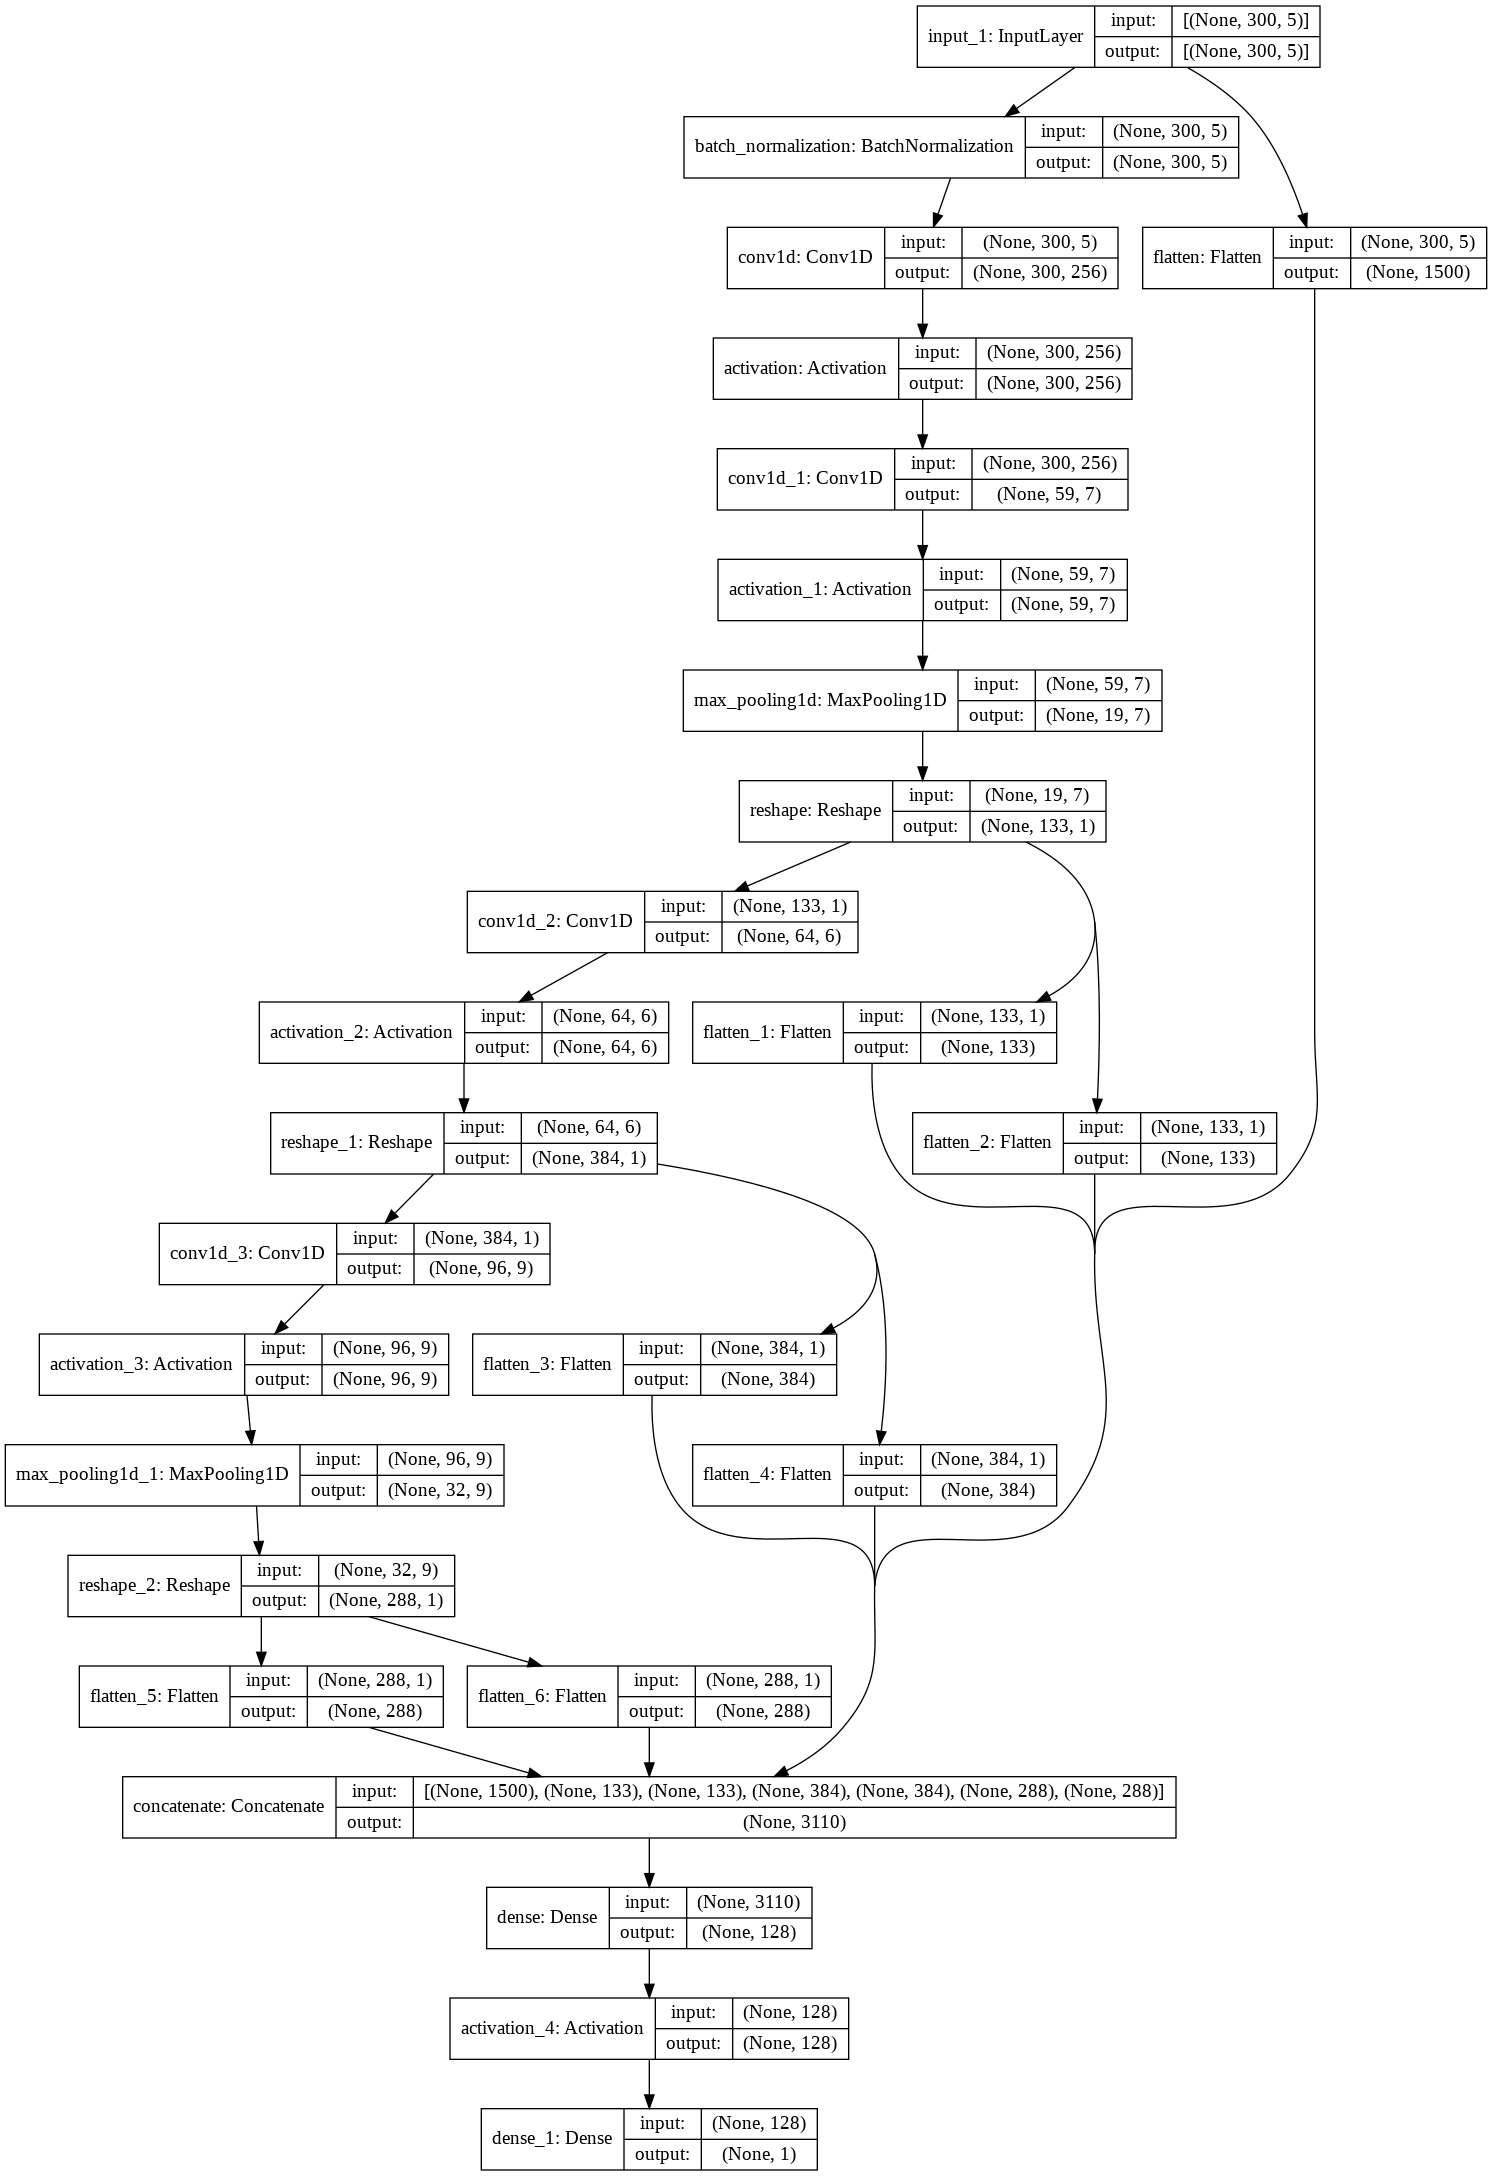

In [ ]:
plot_model(model, show_shapes=True)

## Функция оценки бота

Как и в прошлых задачах по генетическому отбору - нужно сформировать функцию оценки работы бота по значению которой бы будем сортировать нужным образом ботов для поиска лучших.

В задаче предсказания следущего шага на основе определенного количества `xLen` предыдущих, кроме самой точности предсказания важно оценивать и наличие корреляции автокорреляции.

Это сложная задача, так как надо искать и по точности предсказания и по отсутсвию корреляции. То есть мы должны минимизировать и точность на проверочной выбрки и сверить графики корреляции эталонный(данные сами с собой) и график крреляции на основе предсказания и искать вариант сети с минимальной  разницой на первых 5ти шагах (все как в лекции "Базовый блок | Обработка временных рядов с помощью нейронных сетей").

- нам нужно получить точность модели при обучении хотя бы на 3х эпохах.Это мы получаем при обучении на `fit()`
- нм нужно оценить расхождение графиков автокорреляции. Это можно оценить сверив функциeй `MAE()` список двух автокорреляционных данных.

Далее есть разные подходы и все они имеют плюсы и минусы:
- можно перемножить оби ошики, тогда получая по каждой ошибке расхождения мы будем усменьшать общую ошибку. Плюс в том, что такой подход позволяет поиску лучше сходится, минус в том, что если какой-то бот выдаст случайно минимум сильный по одной ошибке, то другие не смогут его перебыть даже с полее сбалансироваными ошибками.
- можно ошибки складывать и даже каждуюю умножать на свой множитль, давая каждой ошибке свою значимость. Плюс в том, что можно искать более сбалансированую пропорцию, но большой минус в том, что такой подход может давать плохую сходимость к лучшему, так как много локальных минимумов, а поиск долгий!!

В озьмем произведение ошибку от `fit()` на последней эпохе с оценкой по автокорреляции на 3шага.




In [ ]:
def eval_net(net,
             ep,
             verb,
             xData,
             yData,
             xLen,
             channels,
             num_cls,
             x_test,
             y_test,
             Scaler
             ):
  '''
  Функция вычисления результатов работы сети:
  
  -----------------
  Входные данные:
  net - бот популяции;
  ep - к-во эпох проверки нс;
  verb - выводить или нет процесс обучения нс на эпохе;
  xData - тренировочные данные;
  yData - проверочные данные;
  xLen - количество подаваемых шагов в наборе;
  channels - количество каналов данных в наборе;
  num_cls - на сколько предсказываем;
  x_test - x тестовая выборка;
  y_test - y тестовая выборка;
  Scaler - скейлер данных;
  ------------------------
  На выходе функции:
  val - на выходе функции оценка работы нс на эпохах проверки
  '''
  val = 0
  model = create_randnet(net, xLen,  channels, num_cls) # Создаем модель createConvNet
  
  # Компилируем модель
  model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mse')
  print('Обучение модели бота', net)
  history = model.fit(xData,
                    epochs=ep, 
                    verbose=verb,
                    validation_data=yData)
    

  # Прогнозируем данные текущей сетью
  y_pred, y_true = get_pred(model, x_test, y_test, Scaler) #Прогнозируем данные

  print('Сохранение оценки бота') 
  # Возвращаем автокорреляцию 
  corr, own_corr = auto_corr([0], 3, y_pred, y_true, plot_graf = False, return_data = True)
  val = MAE(corr, own_corr).numpy()*history.history["val_loss"][-1]# Считаем MAE и прибавляем ошибку
  
  return val                      # Возвращаем точность

Применим функцию `eval_net()` к нашему случайному боту. Функция создать сеть и оценит ее, вернув значение итоговой ошибкий

In [ ]:
eval_net(bot,               # бот популяции 
            3,              # к-во эпох проверки 
            1,              # выводить или нет процесс обучения 
            train_datagen,  # тренировочные данные
            val_datagen,    # проверочные данные
            inputShape[1],  # количество подаваемых шагов в наборе
            inputShape[2],  # количество каналов данных в наборе
            y_test.shape[1], # на сколько предсказываем 
            x_test,         # тестовая выборка
            y_test,         # тестовая выборка
            y_scaler        # скейлер данных
            )

Обучение модели бота [1, 0, 8, 5, 3, 3, 0.1, 0, 2, 3, 0, 3, 6, 2, 'valid', 5, 1, 0, 5, 7, 5, 'valid', 4, 0, 1, 7, 6, 5, 'valid', 6, 1, 1, 6, 6, 2, 'valid', 4, 0, 1, 9, 2, 4, 'same', 0, 1, 1, 7, 2]
Epoch 1/3
901/901 [==============================] - 25s 7ms/step - loss: 0.0514 - val_loss: 0.0786
Epoch 2/3
901/901 [==============================] - 6s 6ms/step - loss: 0.0015 - val_loss: 0.2086
Epoch 3/3
901/901 [==============================] - 6s 6ms/step - loss: 0.0140 - val_loss: 0.2054
Сохранение оценки бота


0.13412316075277622

## Поиск

Код поиска аналогичен коду поиска из лекции для линейной сети

За основу генетического отбора берется код из поиск линейной нейросети.

Мы усложнили архитектуру нейросети так как дали возможность создаваться различным типам внутренних веток (в пределе 5ти), внеся эти параметры в бот.

Нам необходимо защитить такие гены от случйного скрещивания и мутации, вынеся их в список и брать в эти гены только одного родителя.

Также, чтобы добавить в поиск вариативность мы будем каждую эпоху еще создавать и чисто случайные сети, в надежде, что на какой-то эпохе может случайно появиться новая сеть с лучшими или такими же высокими результатами

Применим котроль за поиском(как и были в линейной сети), чтобы отсечь момент когда поиск уже не дает нужного прироста в точности лучшего бота и уже пора закончить поискю. Для этого будем собирать в список `sval_best` точность первых лучших ботов каждой эпохи, и начиная с 5ть эпохи после очередого добавления и сортировки будем оставлять только 5ть и проверять этот список методом `np.std()` на среднее отклонения в нем. И если оно ниже контрольного, то поиск завершаем!

Тем самым мы можем искать эффективнее и не ждать если уже нет уменьшения в ошибке.

In [ ]:
'''
Основные параметры для поиска
'''
n = 15              # Общее число ботов
nsurv = 5           # Количество выживших (столько лучших переходит в новую популяцию)
newrand = 5
nnew = n - nsurv - newrand    # Количество новых (столько новых ботов создается)
l = 48              # Размер бота
epohs = 20          # количество эпох поиска
control_std = 0.0003 # выход из поиска если изменение в лучших ниже данного значения

'''
Особенности мутации
'''
mut = 0.5        # стартовый коэфициент мутаций
eph_change_mut = (2, 4, 6, 8) # эпохи смены коэфициента мутации
new_mut = (0.4, 0.3, 0.2, 0.1) # новый коэфициент мутаци

'''
Защищенные гены
'''
notchangeidx = (7, 8, 9) # индексы бота защищенные и скрещивания от мутации
notmutidx = (5, 6) # индексы бота защищенные от мутации


'''
Создаём популяцию случайных ботов
'''
popul = []         # Массив популяции
val = []           # Одномерный массив значений этих ботов
for i in range(n):
    popul.append(create_bot4net())


'''
Основной цикл поиска
'''  
sval_best = []    # Одномерный массив значений лучших ботов на эпохах
# Пробегаем по всем эпохам
for it in range(epohs):                 
    # проверяем текущую эпоху it на принадлежность графику смены мутации
    if it in eph_change_mut:
        idx = eph_change_mut.index(it) # получаем индекс  по эпохе
        mut = new_mut[idx] # проверяем текущую эпохуобновляем мутацию
        print('Смена мутации на', mut)
        print()  

    val = []                              # Обнуляем значения бота
    curr_time = time.time()               # засекаем время

    '''
    Получение оценок ботов
    '''  
    # Пробегаем в цикле по всем ботам 
    for i in range(n):                    
        bot = popul[i]                     # Берем очередного бота

        # Вычисляем точность текущего бота
        f = eval_net(bot,           # бот популяции 
                    3,              # к-во эпох проверки 
                    0,              # выводить или нет процесс обучения 
                    train_datagen,  # тренировочные данные
                    val_datagen,    # проверочные данные
                    inputShape[1],  # количество подаваемых шагов в наборе
                    inputShape[2],  # количество каналов данных в наборе
                    outputShape[1], # на сколько предсказываем 
                    x_test,         # тестовая выборка
                    y_test,         # тестовая выборка
                    y_scaler        # скейлер данных
                    ) 
        val.append(f)   # Добавляем полученное значение в список val
    
    '''
    Сортировка оценок ботов и контроль поиса
    ''' 
    sval = sorted(val, reverse=0)         # Сортируем val
    # Выводим 5 лучших ботов
    print(it, time.time() - curr_time, " ", sval[0:5],popul[:5]) 

    sval_best.append(sval[0])             # добавляем значение лучшего бота
    # проверка на продолжение поиска, есть разница или уже нет в точности
    if it > 5:                            # с 6й эпохи 
        sval_best = sorted(sval_best, reverse=0)[:5] # сортируем и берем 5ть лучших 
        if np.std(sval_best) < control_std:          # сверяем значения на отличие 
            print('Поиск дучших не дает нового, выход')
            break

    '''
    Сохранение лучших ботов в newpopul
    '''  
    newpopul = [] # Создаем пустой список под новую популяцию
    # Пробегаем по всем выжившим ботам
    for i in range(nsurv):
        # Получаем индекс очередного бота из списка лучших в списке val             
        index = val.index(sval[i])
        # Добавляем в новую популяцию бота из popul с индексом index        
        newpopul.append(popul[index])       
    '''
    Создание новых ботов на основе лучших ботов в newpopul.
    Иногда дополнительно применение мутации и исключения!
    '''
    # Проходимся в цикле nnew-раз 
    for i in range(nnew):
        # случайный выбор родителя в диапазоне от 0 до nsurv - 1              
        indexp1 = random.randint(0,nsurv-1) # Случайный индекс 1го родителя 
        indexp2 = random.randint(0,nsurv-1) # Случайный индекс 1го родителя
        botp1 = newpopul[indexp1]           # бота-родителя 1 по indexp1
        botp2 = newpopul[indexp2]           # бота-родителя  2 по indexp2    
        newbot = []                         # пустой список для нового бота    
        net4Mut = create_bot4net()         # Создаем случайную сеть для мутаций

        # выбираем основного родителя для защищенных генов
        randparent = random.choice((botp1,botp2))

        '''
        Пробегаем по всем генам бота
        '''
        for j in range(l): 
            # Если ген незащищен от скрещивания 
            if j not in notchangeidx:                       
                x = 0      
                '''
                Скрещивание
                '''
                # Получаем случайное число в диапазоне от 0 до 1
                pindex = random.random() 
                # Если pindex меньше 0.5, то берем значения от 1 бота, иначе от 2
                if pindex < 0.5: x = botp1[j]
                else: x = botp2[j]
                
                '''
                Мутация
                '''
                # Если ген незащищен от мутации
                if j not in notmutidx:
                    # С вероятностью mut устанавливаем значение бота из net4Mut
                    if (random.random() < mut): x = net4Mut[j]
                    else: pass

                # Если ген защищен берем от основного         
                else: x = randparent[j]
            # Если ген защищен берем от осноаного
            else: x = randparent[j]
            newbot.append(x)    # Добавляем очередное значение в нового бота      
        newpopul.append(newbot) # Добавляем бота в новую популяцию      
        '''
        Добавление случайных ботов для разнообразия
        ''' 
        for i in range(newrand):
            newpopul.append(create_bot4net())
    popul = newpopul   

Обучение модели бота [1, 0, 5, 5, 0, 3, 0.1, 1, 3, 1, 1, 9, 7, 4, 'valid', 3, 0, 1, 7, 4, 2, 'valid', 0, 0, 1, 6, 6, 5, 'valid', 0, 1, 1, 7, 3, 3, 'valid', 2, 0, 0, 10, 2, 1, 'valid', 0, 1, 0, 7, 2]
Сохранение оценки бота
Обучение модели бота [1, 1, 10, 4, 6, 4, 0.2, 1, 0, 4, 1, 4, 7, 1, 'valid', 1, 1, 1, 4, 2, 2, 'same', 1, 1, 1, 10, 5, 5, 'same', 4, 0, 0, 5, 4, 3, 'valid', 4, 1, 1, 8, 4, 5, 'same', 4, 1, 0, 3, 2]
Сохранение оценки бота
Обучение модели бота [1, 1, 3, 7, 4, 3, 0.2, 1, 0, 4, 0, 4, 4, 3, 'same', 6, 0, 0, 3, 3, 5, 'valid', 2, 0, 1, 4, 5, 4, 'valid', 2, 0, 1, 5, 6, 1, 'valid', 2, 0, 0, 7, 4, 4, 'same', 5, 1, 0, 5, 2]
Сохранение оценки бота
Обучение модели бота [1, 1, 10, 3, 4, 3, 0.1, 0, 1, 4, 0, 4, 3, 4, 'valid', 5, 1, 1, 6, 7, 2, 'valid', 3, 0, 0, 9, 4, 5, 'same', 6, 0, 0, 6, 4, 2, 'valid', 4, 1, 1, 4, 7, 3, 'same', 1, 0, 1, 5, 6]
Сохранение оценки бота
Обучение модели бота [1, 1, 5, 6, 2, 2, 0.3, 0, 4, 1, 1, 8, 2, 5, 'same', 6, 1, 0, 4, 6, 5, 'same', 4, 0, 1, 3, 7, 4, '

Поиск остановился, так изменения точности лучших ниже порога

In [ ]:
for bot in popul[:3]: 
    print(bot) #Геномы лучших ботов по эпохам

[0, 1, 7, 5, 4, 3, 0.1, 0, 1, 4, 1, 3, 7, 3, 'same', 0, 0, 0, 7, 4, 3, 'valid', 1, 0, 0, 3, 6, 2, 'same', 4, 1, 0, 3, 2, 4, 'same', 2, 1, 0, 5, 7, 1, 'same', 6, 1, 1, 6, 4]
[0, 1, 4, 2, 1, 3, 0.2, 0, 2, 3, 1, 9, 7, 1, 'valid', 6, 1, 0, 3, 3, 4, 'valid', 3, 1, 0, 10, 6, 2, 'valid', 2, 1, 0, 9, 4, 4, 'same', 3, 1, 0, 5, 3, 2, 'same', 4, 0, 0, 8, 5]
[1, 0, 7, 5, 2, 3, 0.2, 1, 4, 0, 0, 10, 3, 5, 'same', 1, 0, 0, 10, 2, 1, 'valid', 2, 1, 0, 9, 6, 5, 'same', 3, 1, 1, 10, 5, 2, 'same', 5, 1, 0, 8, 6, 2, 'same', 1, 0, 1, 9, 0]


## Проверка результата

###  Первый бот

In [ ]:
bot = popul[0]
print(bot)
model_1 = create_randnet(bot,
                      inputShape[1],
                      inputShape[2],
                      outputShape[1])
model_1.summary()


[0, 1, 7, 5, 4, 3, 0.1, 0, 1, 4, 1, 3, 7, 3, 'same', 0, 0, 0, 7, 4, 3, 'valid', 1, 0, 0, 3, 6, 2, 'same', 4, 1, 0, 3, 2, 4, 'same', 2, 1, 0, 5, 7, 1, 'same', 6, 1, 1, 6, 4]
Model: "model_197"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_198 (InputLayer)          [(None, 300, 5)]     0                                            
__________________________________________________________________________________________________
dense_657 (Dense)               (None, 300, 128)     768         input_198[0][0]                  
__________________________________________________________________________________________________
activation_751 (Activation)     (None, 300, 128)     0           dense_657[0][0]                  
__________________________________________________________________________________________________
dense_658 (Dense

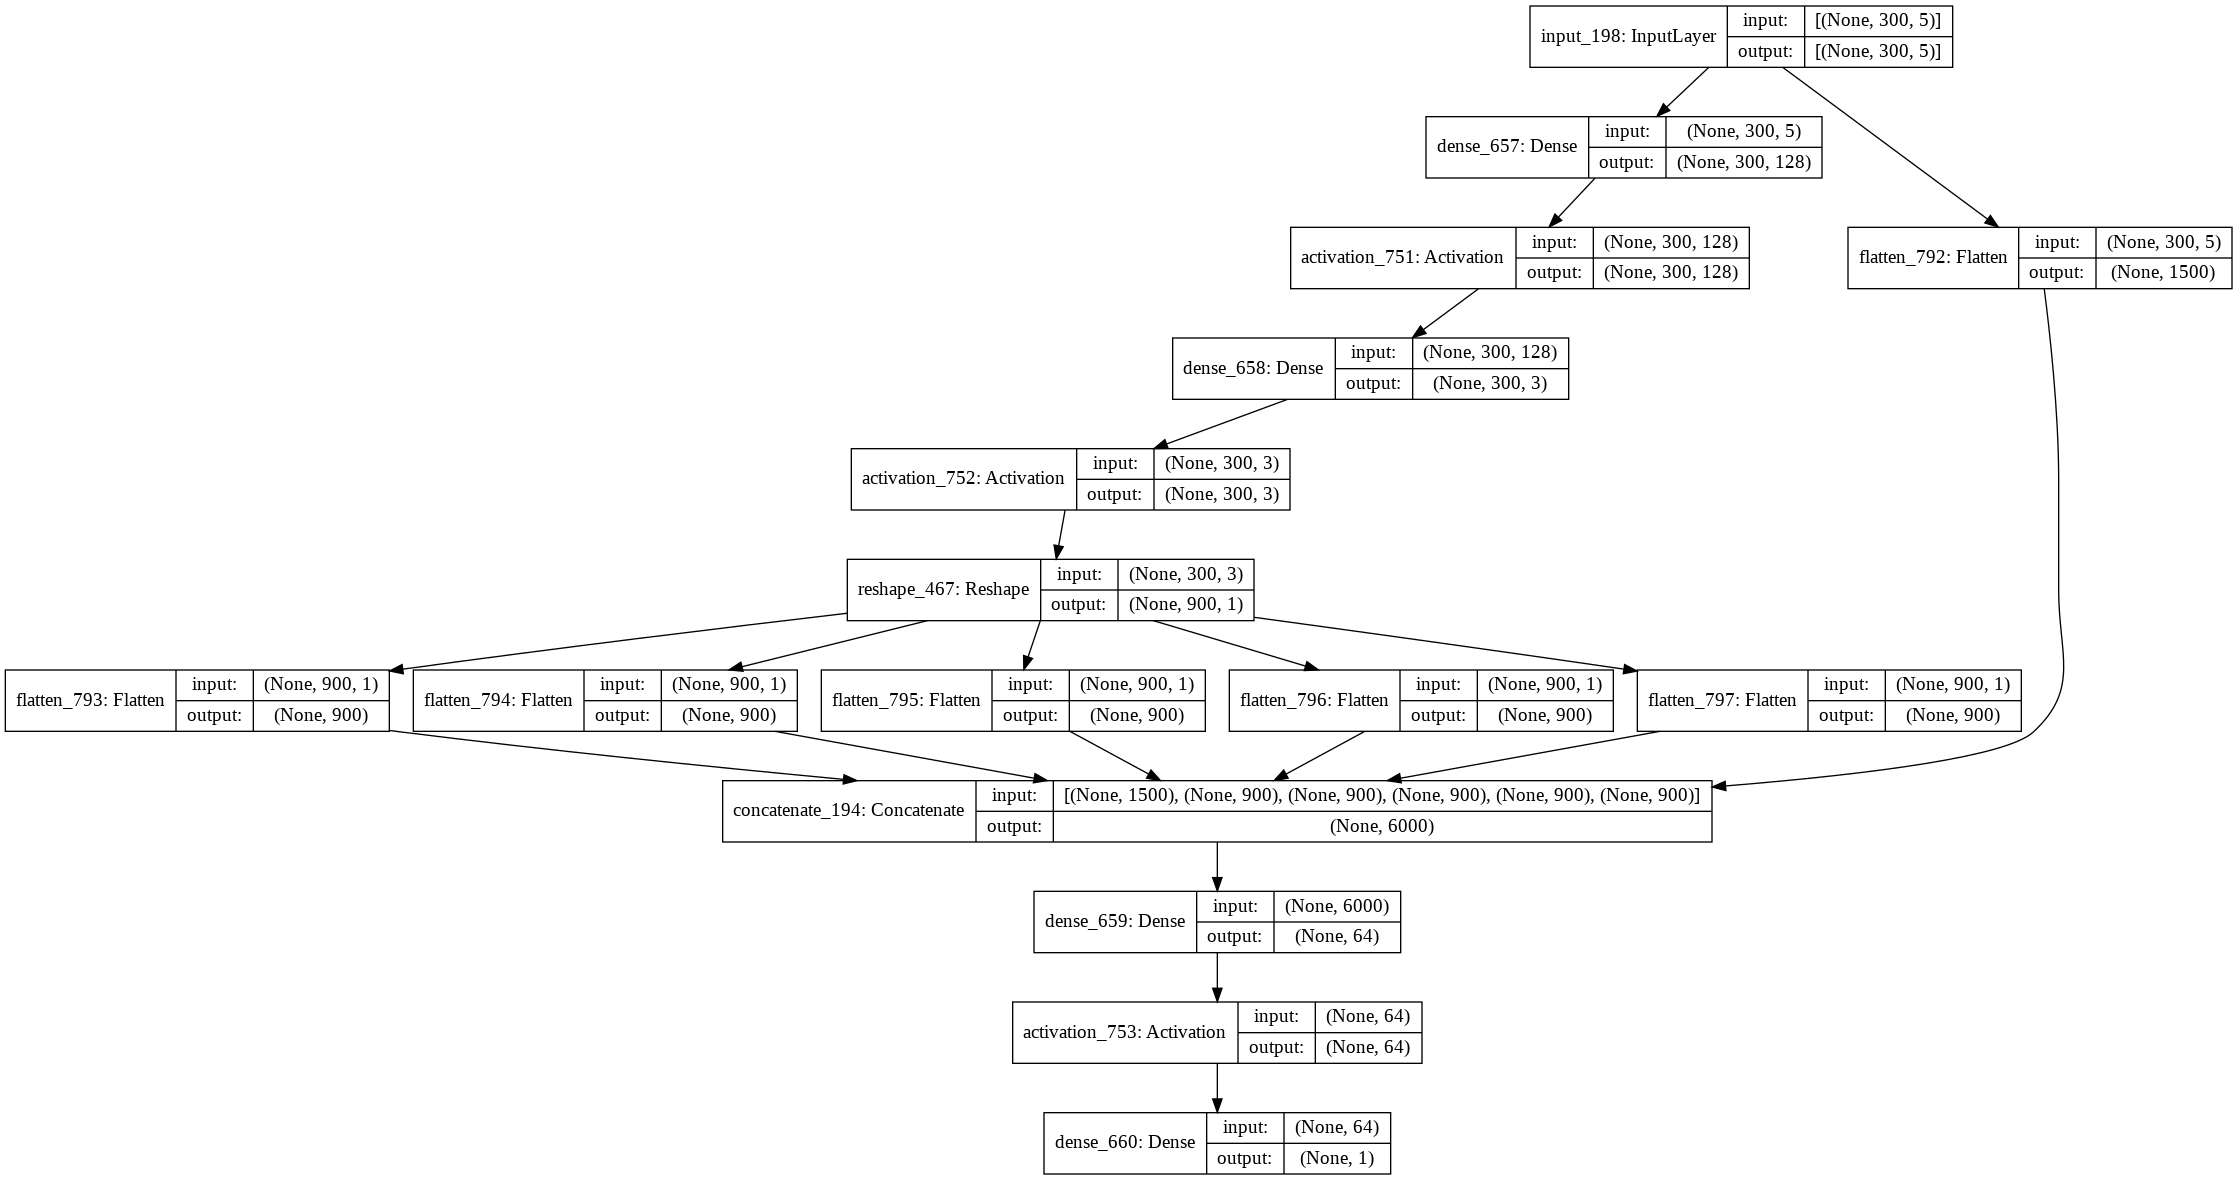

In [ ]:
plot_model(model_1, show_shapes=True)

In [ ]:
epoch_list = [(5, Adam(learning_rate=1e-4)),
              (10, Adam(learning_rate=1e-5)),
              (10, Adam(learning_rate=1e-6)),
              (12, Adam(learning_rate=1e-7)),
              (13, Adam(learning_rate=1e-8)),
              ]
epochs = 0
for elem in epoch_list: epochs += elem[0]

val_loss = []
loss= []
#Комипилируем и обучаем
for epoch_lr, opt in epoch_list:
    model_1.compile(optimizer=opt,
                    loss='mse')
    history = model_1.fit(train_datagen,                             
                        epochs=epoch_lr, 
                        validation_data=val_datagen)
    val_loss.extend(history.history['val_loss'])
    loss.extend(history.history['loss'])
    
results = {'loss':loss, 'val_loss':val_loss}



Epoch 1/5
901/901 [==============================] - 5s 5ms/step - loss: 0.0159 - val_loss: 5.8285e-04
Epoch 2/5
901/901 [==============================] - 4s 5ms/step - loss: 0.0023 - val_loss: 4.9739e-04
Epoch 3/5
901/901 [==============================] - 4s 5ms/step - loss: 9.1467e-04 - val_loss: 3.3208e-04
Epoch 4/5
901/901 [==============================] - 4s 5ms/step - loss: 0.0021 - val_loss: 6.0101e-04
Epoch 5/5
901/901 [==============================] - 4s 5ms/step - loss: 6.6733e-04 - val_loss: 2.0070e-04
Epoch 1/10
901/901 [==============================] - 6s 5ms/step - loss: 2.3211e-04 - val_loss: 1.9334e-04
Epoch 2/10
901/901 [==============================] - 4s 5ms/step - loss: 2.3856e-04 - val_loss: 5.1011e-04
Epoch 3/10
901/901 [==============================] - 4s 5ms/step - loss: 2.0095e-04 - val_loss: 9.3093e-04
Epoch 4/10
901/901 [==============================] - 4s 5ms/step - loss: 1.9947e-04 - val_loss: 8.9864e-04
Epoch 5/10
901/901 [=========================

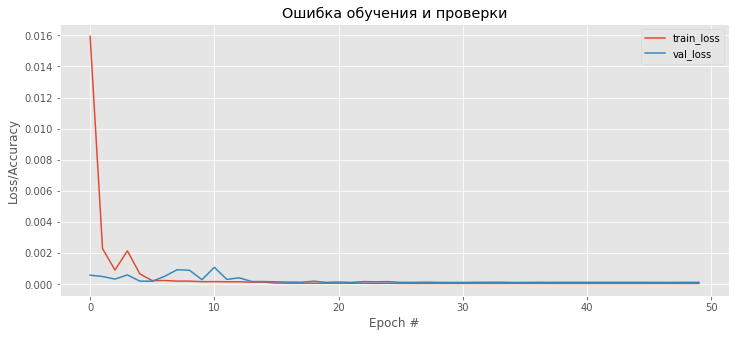

In [ ]:
# строим графики потерь и точности
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure(figsize=(12, 5))
plt.plot(N, results["loss"], label="train_loss")
plt.plot(N, results["val_loss"], label="val_loss")
plt.title("Ошибка обучения и проверки") 
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


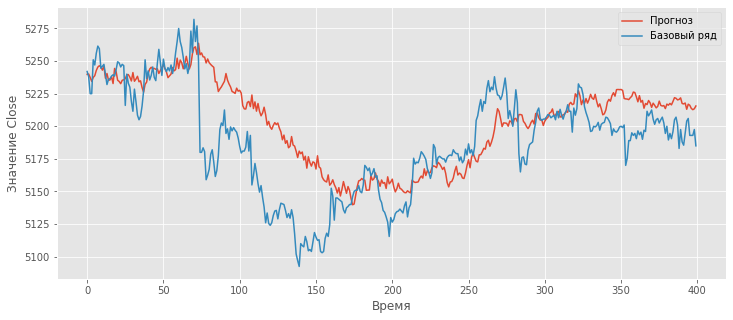

In [ ]:
# Прогнозируем данные текущей сетью
(predVal, yValUnscaled) = get_pred(model_1, x_test,
                                            y_test,
                                            y_scaler) #Прогнозируем данные

# Отображаем графики
show_predict(0, 400, 0, predVal, yValUnscaled)

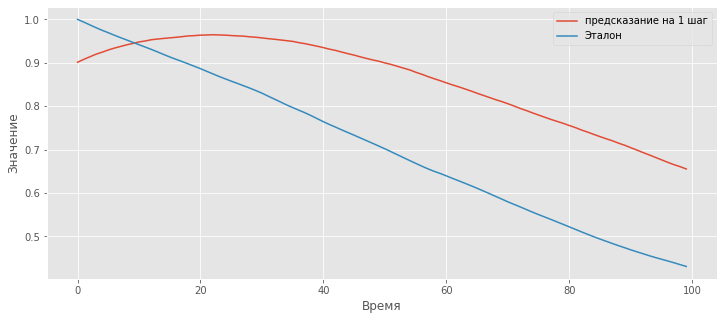

In [ ]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину 60 шагов
auto_corr([0], 100, predVal, yValUnscaled)

### Второй бот

In [ ]:
bot = popul[1]
print(bot)
model_2 = create_randnet(bot,
                      inputShape[1],
                      inputShape[2],
                      outputShape[1])
model_2.summary()


[0, 1, 4, 2, 1, 3, 0.2, 0, 2, 3, 1, 9, 7, 1, 'valid', 6, 1, 0, 3, 3, 4, 'valid', 3, 1, 0, 10, 6, 2, 'valid', 2, 1, 0, 9, 4, 4, 'same', 3, 1, 0, 5, 3, 2, 'same', 4, 0, 0, 8, 5]
Model: "model_198"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_199 (InputLayer)          [(None, 300, 5)]     0                                            
__________________________________________________________________________________________________
dense_661 (Dense)               (None, 300, 16)      96          input_199[0][0]                  
__________________________________________________________________________________________________
activation_754 (Activation)     (None, 300, 16)      0           dense_661[0][0]                  
__________________________________________________________________________________________________
dense_662 (De

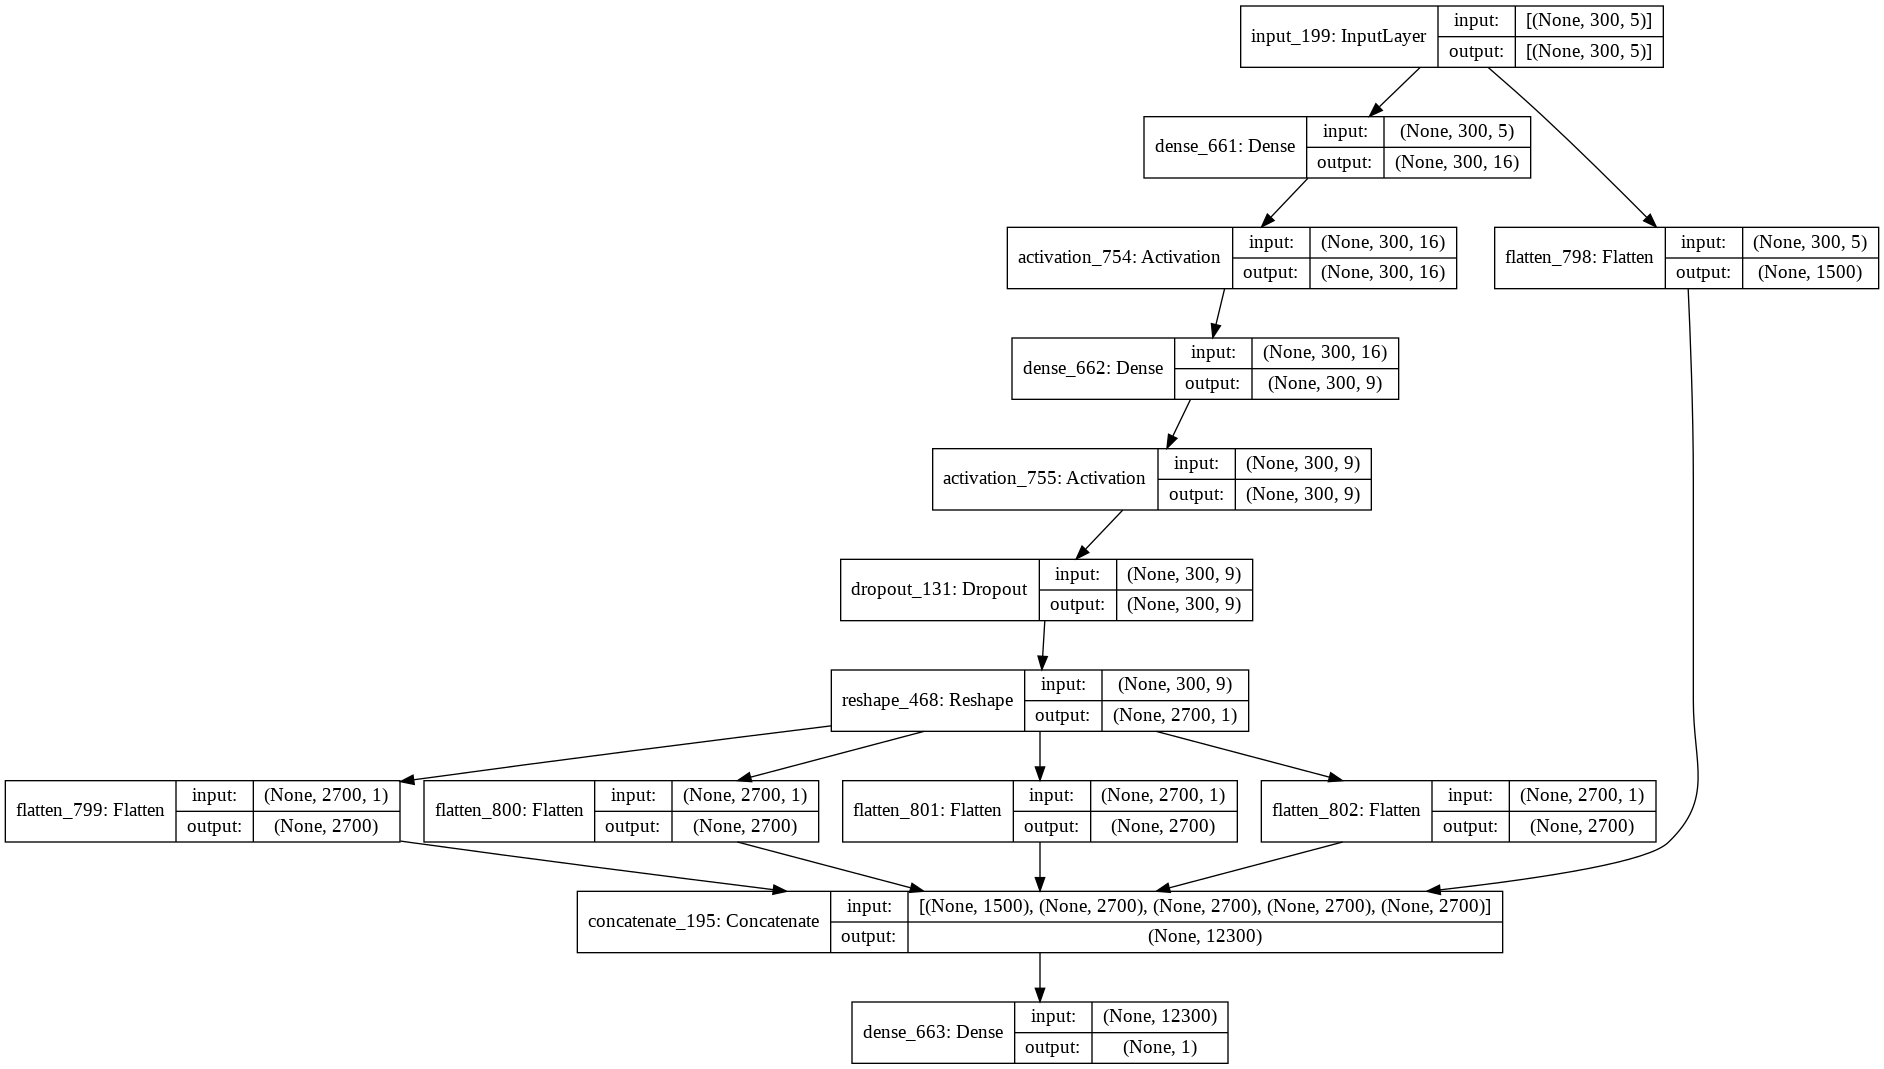

In [ ]:
plot_model(model_2, show_shapes=True)

In [ ]:
epoch_list = [(5, Adam(learning_rate=1e-4)),
              (10, Adam(learning_rate=1e-5)),
              (10, Adam(learning_rate=1e-6)),
              (12, Adam(learning_rate=1e-7)),
              (13, Adam(learning_rate=1e-8)),
              ]
epochs = 0
for elem in epoch_list: epochs += elem[0]

val_loss = []
loss= []
#Комипилируем и обучаем
for epoch_lr, opt in epoch_list:
    model_2.compile(optimizer=opt,
                    loss='mse')
    history = model_2.fit(train_datagen,                             
                        epochs=epoch_lr, 
                        validation_data=val_datagen)
    val_loss.extend(history.history['val_loss'])
    loss.extend(history.history['loss'])
    
results = {'loss':loss, 'val_loss':val_loss}



Epoch 1/5
901/901 [==============================] - 5s 5ms/step - loss: 0.0883 - val_loss: 9.2142e-04
Epoch 2/5
901/901 [==============================] - 4s 5ms/step - loss: 0.0424 - val_loss: 0.0023
Epoch 3/5
901/901 [==============================] - 4s 5ms/step - loss: 0.0189 - val_loss: 2.5556e-04
Epoch 4/5
901/901 [==============================] - 4s 5ms/step - loss: 0.0087 - val_loss: 2.5228e-04
Epoch 5/5
901/901 [==============================] - 4s 5ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 1/10
901/901 [==============================] - 5s 5ms/step - loss: 0.0013 - val_loss: 2.3435e-04
Epoch 2/10
901/901 [==============================] - 4s 5ms/step - loss: 9.5173e-04 - val_loss: 2.3229e-04
Epoch 3/10
901/901 [==============================] - 4s 5ms/step - loss: 7.1485e-04 - val_loss: 2.5926e-04
Epoch 4/10
901/901 [==============================] - 4s 5ms/step - loss: 5.6290e-04 - val_loss: 2.1774e-04
Epoch 5/10
901/901 [==============================] - 4s 5ms/step

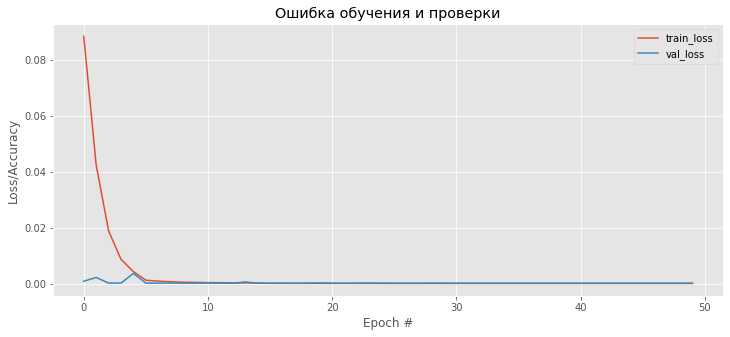

In [ ]:
# строим графики потерь и точности
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure(figsize=(12, 5))
plt.plot(N, results["loss"], label="train_loss")
plt.plot(N, results["val_loss"], label="val_loss")
plt.title("Ошибка обучения и проверки") 
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


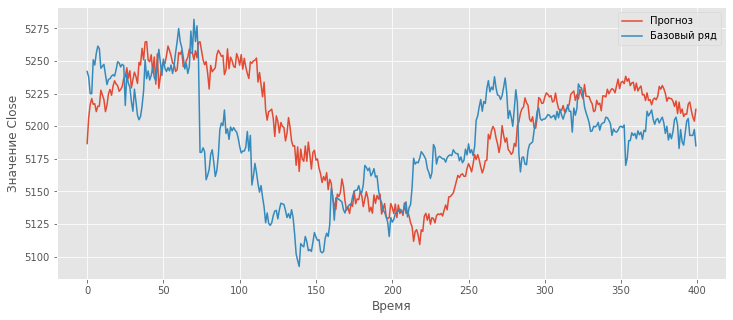

In [ ]:
# Прогнозируем данные текущей сетью
(predVal, yValUnscaled) = get_pred(model_2, x_test,
                                            y_test,
                                            y_scaler) #Прогнозируем данные

# Отображаем графики
show_predict(0, 400, 0, predVal, yValUnscaled)

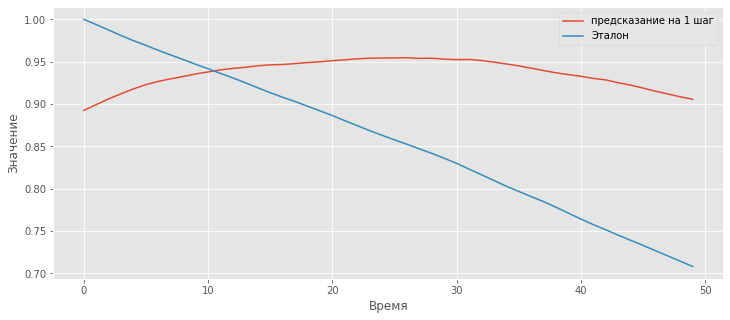

In [ ]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину 60 шагов
auto_corr([0], 50, predVal, yValUnscaled)

### Третий бот

In [ ]:
bot = popul[2]
print(bot)

model_3 = create_randnet(bot,
                      inputShape[1],
                      inputShape[2],
                      outputShape[1])
model_3.summary()


[1, 0, 7, 5, 2, 3, 0.2, 1, 4, 0, 0, 10, 3, 5, 'same', 1, 0, 0, 10, 2, 1, 'valid', 2, 1, 0, 9, 6, 5, 'same', 3, 1, 1, 10, 5, 2, 'same', 5, 1, 0, 8, 6, 2, 'same', 1, 0, 1, 9, 0]
Model: "model_199"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_200 (InputLayer)          [(None, 300, 5)]     0                                            
__________________________________________________________________________________________________
batch_normalization_80 (BatchNo (None, 300, 5)       20          input_200[0][0]                  
__________________________________________________________________________________________________
conv1d_239 (Conv1D)             (None, 300, 128)     3328        batch_normalization_80[0][0]     
__________________________________________________________________________________________________
activation_75

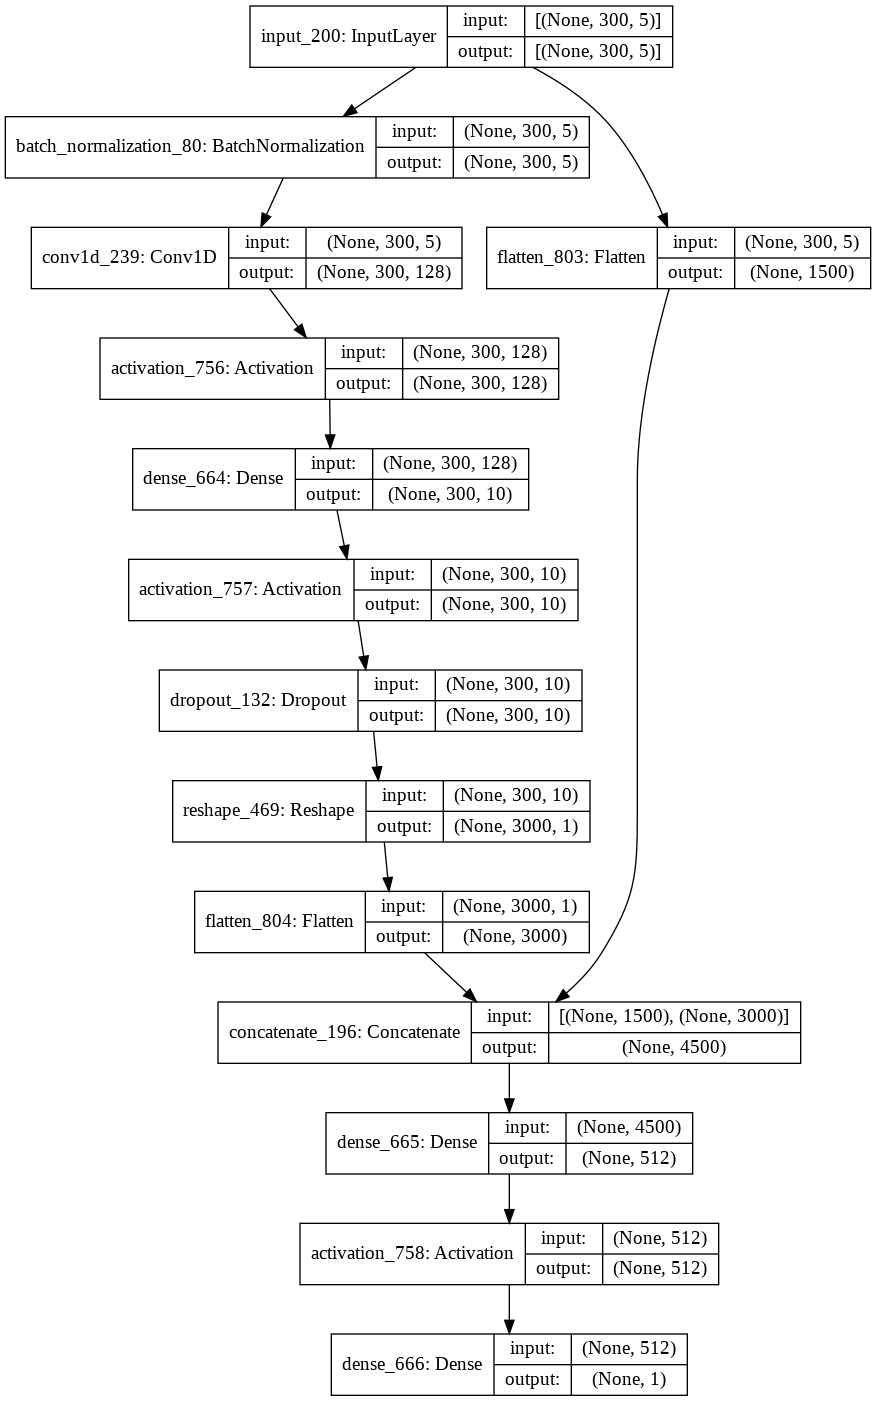

In [ ]:
plot_model(model_3, show_shapes=True)

In [ ]:
epoch_list = [(5, Adam(learning_rate=1e-4)),
              (10, Adam(learning_rate=1e-5)),
              (10, Adam(learning_rate=1e-6)),
              (12, Adam(learning_rate=1e-7)),
              (13, Adam(learning_rate=1e-8)),
              ]
epochs = 0
for elem in epoch_list: epochs += elem[0]             

val_loss = []
loss= []
#Комипилируем и обучаем
for epoch_lr, opt in epoch_list:
    model_3.compile(optimizer=opt,
                    loss='mse')
    history = model_3.fit(train_datagen,                             
                        epochs=epoch_lr, 
                        validation_data=val_datagen)
    val_loss.extend(history.history['val_loss'])
    loss.extend(history.history['loss'])
    
results = {'loss':loss, 'val_loss':val_loss}



Epoch 1/5
901/901 [==============================] - 6s 6ms/step - loss: 0.3195 - val_loss: 0.8324
Epoch 2/5
901/901 [==============================] - 5s 6ms/step - loss: 0.0713 - val_loss: 0.0162
Epoch 3/5
901/901 [==============================] - 5s 6ms/step - loss: 0.2302 - val_loss: 0.0080
Epoch 4/5
901/901 [==============================] - 5s 6ms/step - loss: 0.0636 - val_loss: 0.0054
Epoch 5/5
901/901 [==============================] - 5s 6ms/step - loss: 0.0610 - val_loss: 0.0271
Epoch 1/10
901/901 [==============================] - 6s 6ms/step - loss: 0.0029 - val_loss: 0.0173
Epoch 2/10
901/901 [==============================] - 5s 6ms/step - loss: 0.0023 - val_loss: 0.0074
Epoch 3/10
901/901 [==============================] - 5s 6ms/step - loss: 0.0022 - val_loss: 0.0125
Epoch 4/10
901/901 [==============================] - 5s 6ms/step - loss: 0.0022 - val_loss: 0.0052
Epoch 5/10
901/901 [==============================] - 5s 6ms/step - loss: 8.8645e-04 - val_loss: 0.0058
E

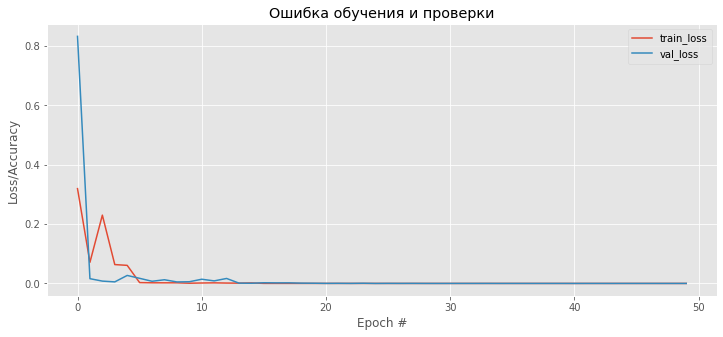

In [ ]:
# строим графики потерь и точности
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure(figsize=(12, 5))
plt.plot(N, results["loss"], label="train_loss")
plt.plot(N, results["val_loss"], label="val_loss")
plt.title("Ошибка обучения и проверки") 
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


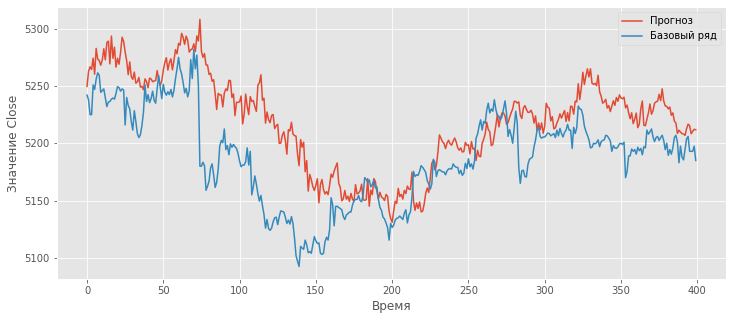

In [ ]:
# Прогнозируем данные текущей сетью
(predVal, yValUnscaled) = get_pred(model_3, x_test,
                                            y_test,
                                            y_scaler) #Прогнозируем данные

# Отображаем графики
show_predict(0, 400, 0, predVal, yValUnscaled)

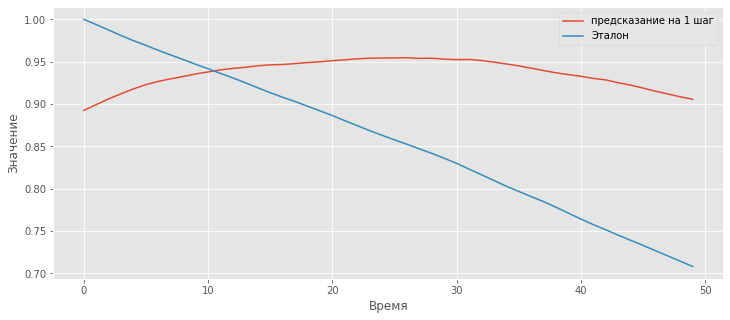

In [ ]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину 60 шагов
auto_corr([0], 50, predVal, yValUnscaled)

# Пример "человеческой сборки" нелинейной сети


In [ ]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину shape = (xLen, 1)
shape = (inputShape[1], inputShape[2])

inputs = Input(shape)
list_to_concat = [inputs]


x = Conv1D(2**6,3,padding='same')(inputs)
x = Activation('relu')(x)
list_to_concat.append(x)

x = Conv1D(2**6,5,padding='same')(x)
x = Activation('relu')(x)
list_to_concat.append(x)

x = Conv1D(2**8,5,padding='same')(x)
x = Activation('relu')(x)
list_to_concat.append(x)

for i in range(len(list_to_concat)):
  list_to_concat[i]=Flatten()(list_to_concat[i])

fin = concatenate(list_to_concat)
fin = Dense(2**6)(fin)
fin = Activation('linear')(fin)

fin = Dense(1)(fin)

model_conv_hum = Model(inputs, fin)

model_conv_hum.compile(loss="mse", optimizer=Adam(learning_rate=1e-4))

epoch_list = [(7, Adam(learning_rate=1e-4)),
              (10, Adam(learning_rate=1e-5)),
              (10, Adam(learning_rate=1e-6)),
              (13, Adam(learning_rate=1e-7)),
              ]
epochs = 0
for elem in epoch_list: epochs += elem[0]             

val_loss = []
loss= []
#Комипилируем и обучаем
for epoch_lr, opt in epoch_list:
    model_conv_hum.compile(optimizer=opt,
                    loss='mse')
    history = model_conv_hum.fit(train_datagen,                             
                        epochs=epoch_lr, 
                        validation_data=val_datagen)
    val_loss.extend(history.history['val_loss'])
    loss.extend(history.history['loss'])
    
results = {'loss':loss, 'val_loss':val_loss}

Epoch 1/7
901/901 [==============================] - 6s 6ms/step - loss: 0.1870 - val_loss: 1.8767e-04
Epoch 2/7
901/901 [==============================] - 5s 6ms/step - loss: 0.1500 - val_loss: 0.5110
Epoch 3/7
901/901 [==============================] - 5s 6ms/step - loss: 0.0062 - val_loss: 6.3114e-04
Epoch 4/7
901/901 [==============================] - 5s 6ms/step - loss: 0.0411 - val_loss: 0.0015
Epoch 5/7
901/901 [==============================] - 5s 6ms/step - loss: 0.0617 - val_loss: 0.4372
Epoch 6/7
901/901 [==============================] - 5s 6ms/step - loss: 0.0074 - val_loss: 1.5718e-04
Epoch 7/7
901/901 [==============================] - 5s 6ms/step - loss: 0.0078 - val_loss: 0.0088
Epoch 1/10
901/901 [==============================] - 6s 6ms/step - loss: 5.9755e-04 - val_loss: 0.0011
Epoch 2/10
901/901 [==============================] - 5s 6ms/step - loss: 4.8351e-04 - val_loss: 1.0445e-04
Epoch 3/10
901/901 [==============================] - 5s 6ms/step - loss: 2.9896e-0

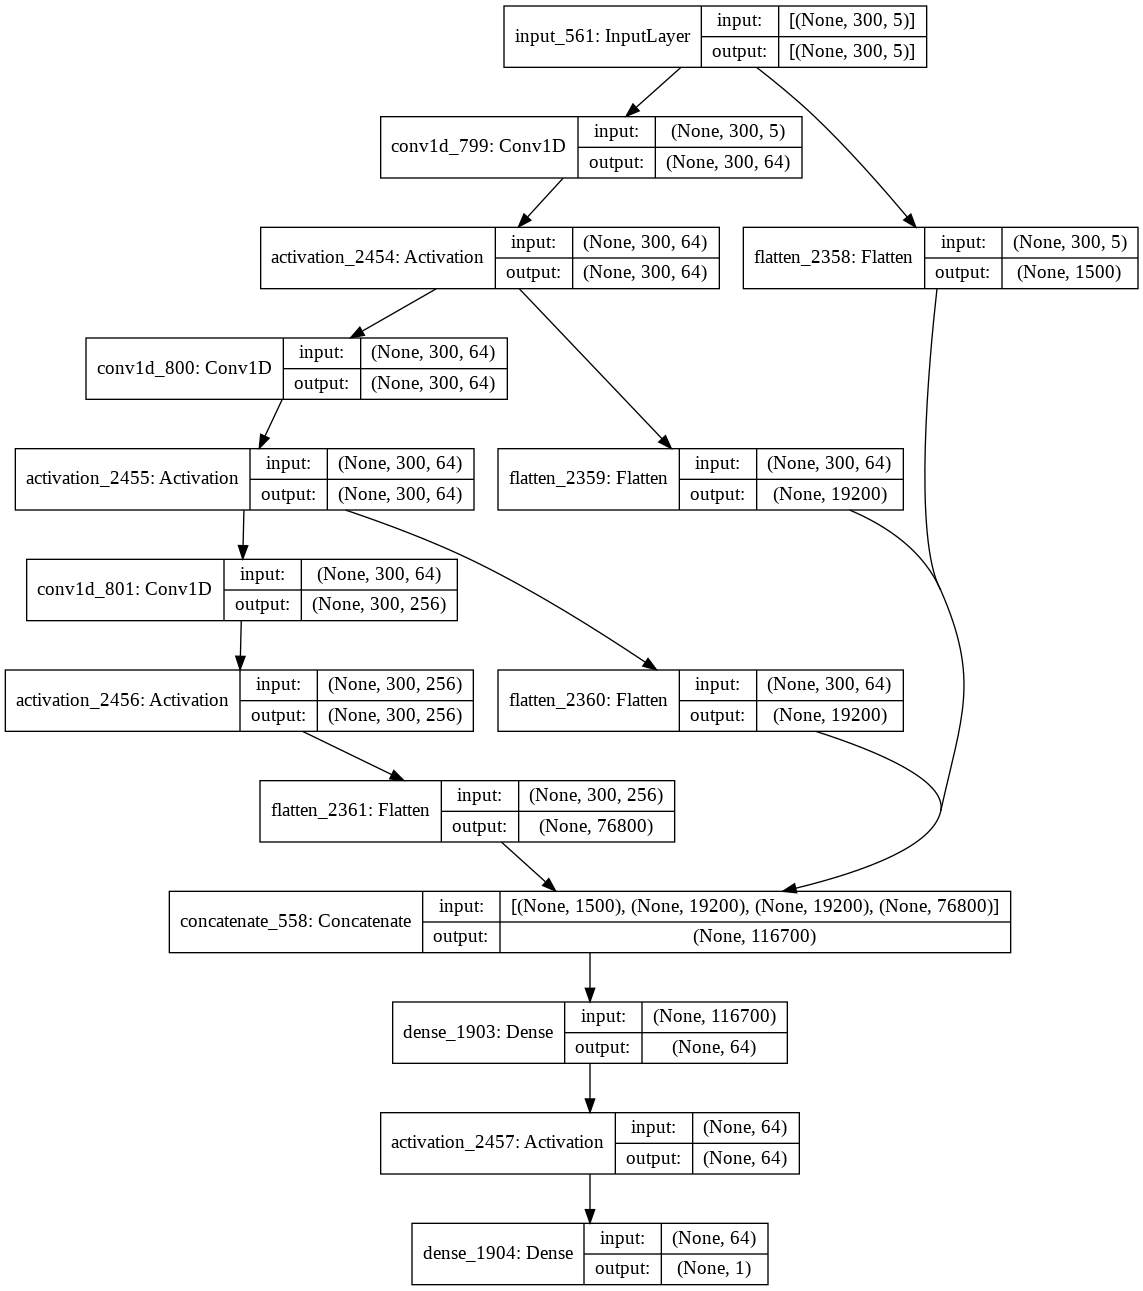

In [ ]:
plot_model(model_conv_hum, show_shapes=True)

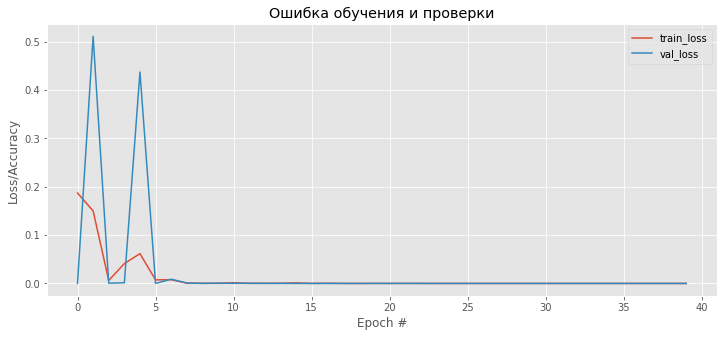

In [ ]:
# строим графики потерь и точности
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure(figsize=(12, 5))
plt.plot(N, results['loss'], label='train_loss')
plt.plot(N, results['val_loss'], label="val_loss")
plt.title("Ошибка обучения и проверки") 
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


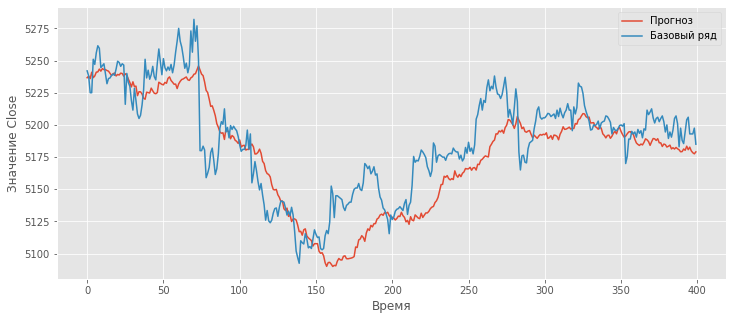

In [ ]:
# Прогнозируем данные текущей сетью
(predVal, yValUnscaled) = get_pred(model_conv_hum,x_test,
                                            y_test,
                                            y_scaler) #Прогнозируем данные

# Отображаем графики
show_predict(0, 400, 0, predVal, yValUnscaled)

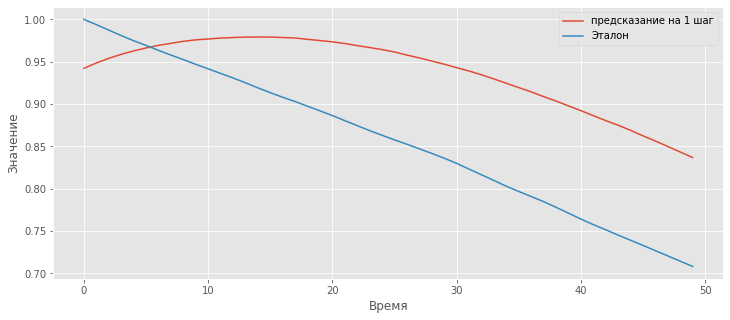

In [ ]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину 60 шагов
auto_corr([0], 50, predVal, yValUnscaled)

# Выводы

В данном ноутбуке показаны методы для поска неленейной сети. Это в целом намного более трудная задача, так как пространство для поиска намного шиире и разнообразнее. По пути могут быть множество локальных минимумов в которых поиск может застрять. 

Но поиск может подсказать какие слои для текущей задаче лучше работают, а какие хуже.

Нередко, упрощение структуры нейросети может благотворно влиять на точность, хотя это и не всегда!

Подобрать модель с хорошими предсказаниями непросто!!!!

**Содержание темы**

1. [Практический ноутбук 1](https://colab.research.google.com/drive/1R9XFt3kobaoX9z3wjFTIIR6DY_dCXSDE?usp=sharing)

2. Практический ноутбук 2
